<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [1]:
from platform import python_version
print(python_version())

3.9.16


In [216]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [217]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: C:\Users\Zver\atm_daily_cash.csv
26.1kB [00:00, 1.05MB/s]                   


Взглянем на то, что представляют из себя данные:

In [218]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [219]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

In [221]:
len(df)

1182

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [222]:
import matplotlib.pyplot as plt

In [2]:
!pip install etna

  Using cached etna-1.15.1-py3-none-any.whl (273 kB)
  Using cached tsfresh-0.20.0-py2.py3-none-any.whl (98 kB)
  Using cached protobuf-3.20.3-cp38-cp38-win_amd64.whl (904 kB)
  Using cached gdown-4.6.4-py3-none-any.whl (14 kB)
  Using cached loguru-0.5.3-py3-none-any.whl (57 kB)
  Using cached numba-0.55.2-cp38-cp38-win_amd64.whl (2.4 MB)
  Using cached ipywidgets-7.7.5-py2.py3-none-any.whl (123 kB)
     ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
     --------------------------------------- 0.0/11.0 MB 660.6 kB/s eta 0:00:17
     --------------------------------------- 0.0/11.0 MB 660.6 kB/s eta 0:00:17
     --------------------------------------- 0.1/11.0 MB 491.5 kB/s eta 0:00:23
     --------------------------------------- 0.1/11.0 MB 547.6 kB/s eta 0:00:20
      -------------------------------------- 0.1/11.0 MB 610.6 kB/s eta 0:00:18
      -------------------------------------- 0.2/11.0 MB 734.2 kB/s eta 0:00:15
      --------------------------------------

In [223]:
import etna


In [225]:
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast,
                           sample_acf_plot, sample_pacf_plot)

In [226]:
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

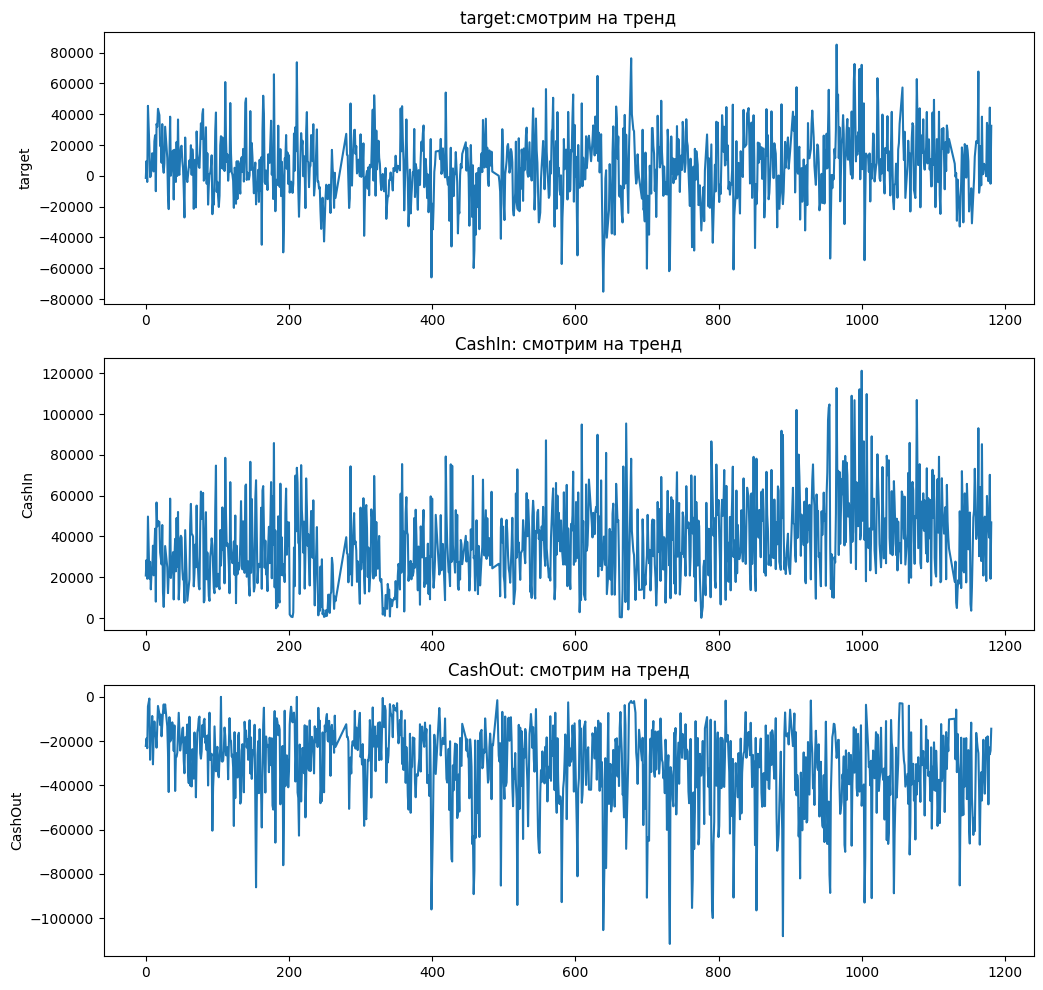

In [80]:

fig, ax = plt.subplots()

plt.subplot(311)
#plt.figure(figsize=(16, 4))
plt.title('target:смотрим на тренд')
sns.lineplot(np.arange(len(df)),df['target'])  

plt.subplot(312)
#plt.figure(figsize=(16, 4))
plt.title('CashIn: смотрим на тренд')
sns.lineplot(np.arange(len(df)),df['CashIn']) 

plt.subplot(313)
#plt.figure(figsize=(16, 4))
plt.title('CashOut: смотрим на тренд')
sns.lineplot(np.arange(len(df)),df['CashOut']) 

fig.set_figwidth(12)    
fig.set_figheight(12)
plt.show()

Все три ряда визуально выглядят как стационарные: колеблются в ограниченном диапазане.У CashIn в конце ряда прослеживается незначительный восходящий тренд. Чтобы строго судить о стационарности рядов, проведём тест Дики-Фуллера на стационарность.

Референс для теста: https://www.codecamp.ru/blog/dickey-fuller-test-python/

Итак, гипотезы теста формулируются следующим образом:

H 0 : Временной ряд является нестационарным.

H A : временной ряд является стационарным.

Уровень значимости примем за 5% - стандартный для исследования экономических данных.

In [227]:
from statsmodels. tsa.stattools import adfuller

In [231]:
# тест на стационарность для target

adfuller(df.dropna()['target'].tolist())

(-8.222847874370718,
 6.360829068712734e-13,
 17,
 1054,
 {'1%': -3.4365694473419928,
  '5%': -2.8642860655788693,
  '10%': -2.568232111086707},
 23829.035529742254)

p-value составляет 6.360829068712734e-13 < 0.05. Следовательно, нулевая гипотеза отвергается в пользу альтернативной, то есть ряд является стационарным.

In [232]:
# тест на стационарность для CashIn

adfuller(df.dropna()['CashIn'].tolist())

(-3.420075669387869,
 0.010293237365450522,
 20,
 1051,
 {'1%': -3.4365872439265366,
  '5%': -2.8642939151214337,
  '10%': -2.568236291810346},
 23661.37842316235)

p-value = 0.010293237365450522 < 0.05. Следовательно, нулевая гипотеза отвергается в пользу альтернативной, то есть ряд является стационарным.

In [233]:
# тест на стационарность для CashOut

adfuller(df.dropna()['CashOut'].tolist())

(-9.313820529246213,
 1.0319215489621378e-15,
 7,
 1064,
 {'1%': -3.436510851955201,
  '5%': -2.864260220574562,
  '10%': -2.5682183458999943},
 23402.13942732342)

p-value = 1.0319215489621378e-15 < 0.05. Следовательно, нулевая гипотеза отвергается в пользу альтернативной, то есть ряд является стационарным.

Итак, все три ряда действительно стационарны.

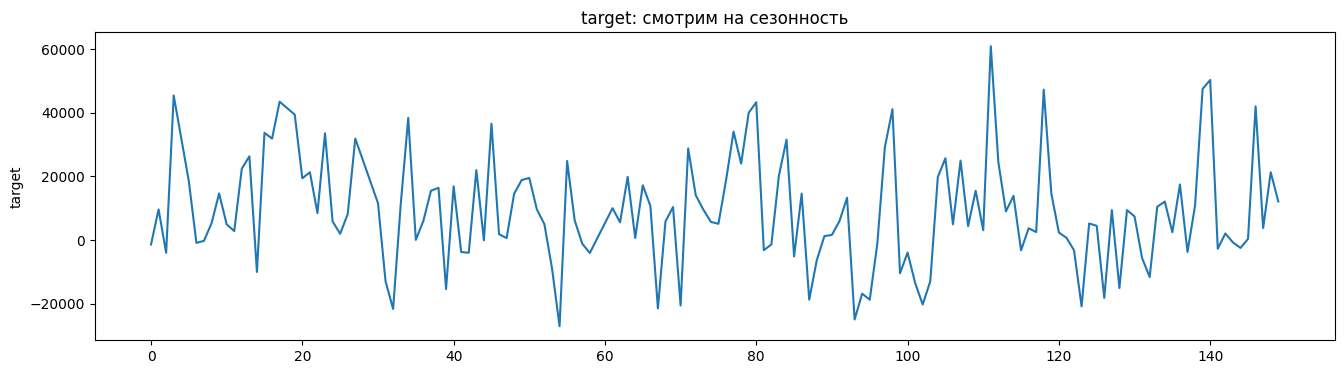

In [35]:
plt.figure(figsize=(16, 4))
plt.title('target: смотрим на сезонность')
sns.lineplot(np.arange(150),df['target'][:150])  
plt.show()

Судя по графику, присутствует сезонность с периодом 7-10 дней. Смотрим строго:

In [143]:
df_target = df.copy()
df_target["timestamp"] = pd.to_datetime(df_target["Date"])
df_target["segment"] = "main"
df_target.drop(columns=["CashIn", "CashOut"], inplace=True)

In [144]:
df_target.head()

Date   target  timestamp segment
4  1/5/2016  -1360.0 2016-01-05    main
5  1/6/2016   9650.0 2016-01-06    main
6  1/7/2016  -3960.0 2016-01-07    main
7  1/8/2016  45420.0 2016-01-08    main
8  1/9/2016      NaN 2016-01-09    main

In [25]:
from etna.datasets import TSDataset

In [145]:
df_target = TSDataset.to_dataset(df_target)
df_target.head()

segment         main         
feature         Date   target
timestamp                    
2016-01-05  1/5/2016  -1360.0
2016-01-06  1/6/2016   9650.0
2016-01-07  1/7/2016  -3960.0
2016-01-08  1/8/2016  45420.0
2016-01-09  1/9/2016      NaN

In [146]:
ts_target = TSDataset(df_target, freq="D")

In [147]:
ts_target.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 1
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2016-01-05    2019-03-31    1182          110


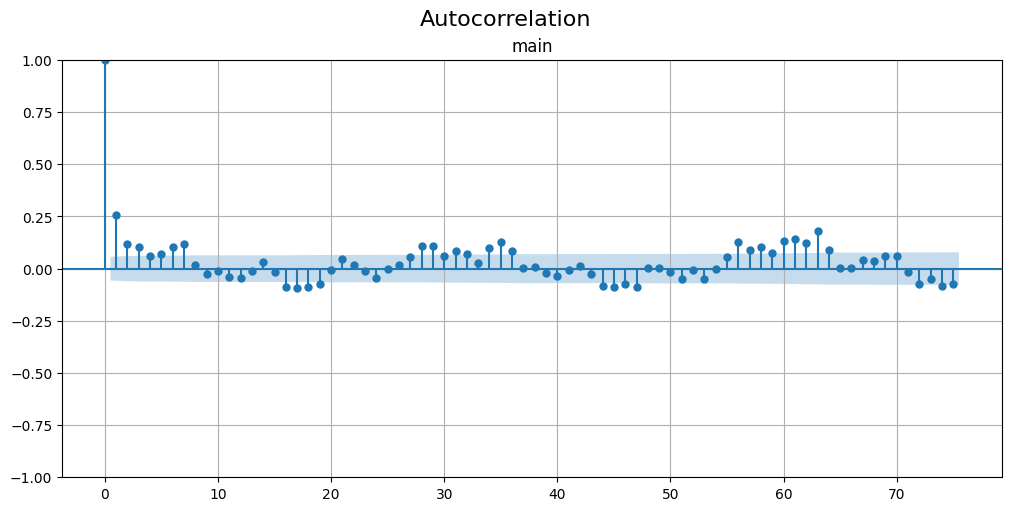

In [156]:
sample_acf_plot(ts_target, lags = 75)

На графике автокорреляционной функции видно, что примерно одинаковый паттерн повторяется на первых лагах с периодом 7-8 дней. Также мы видим, что первый лаг является наиболее значимым, значимы также все лаги за прошлую неделю.

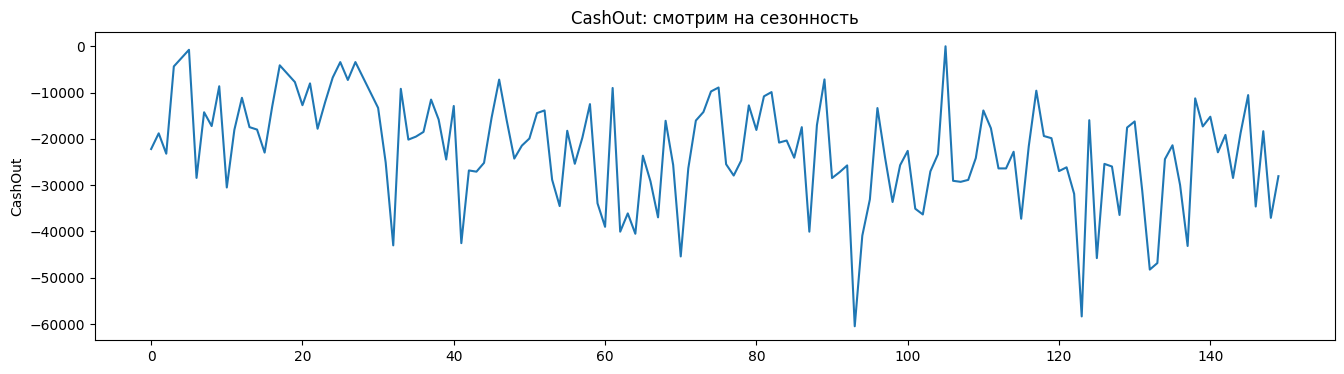

In [70]:
plt.figure(figsize=(16, 4))
plt.title('CashOut: смотрим на сезонность')
sns.lineplot(np.arange(150),df['CashOut'][:150])  
plt.show()

In [149]:
df_in = df.copy()
df_in["timestamp"] = pd.to_datetime(df_in["Date"])
df_in["segment"] = "main"
df_in.drop(columns=["target", "CashOut"], inplace=True)
df_in["target"] = df_in["CashIn"]
df_in.drop(columns=["CashIn"], inplace=True)
df_in = TSDataset.to_dataset(df_in)
ts_in = TSDataset(df_in, freq="D")
ts_in.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 1
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2016-01-05    2019-03-31    1182          101


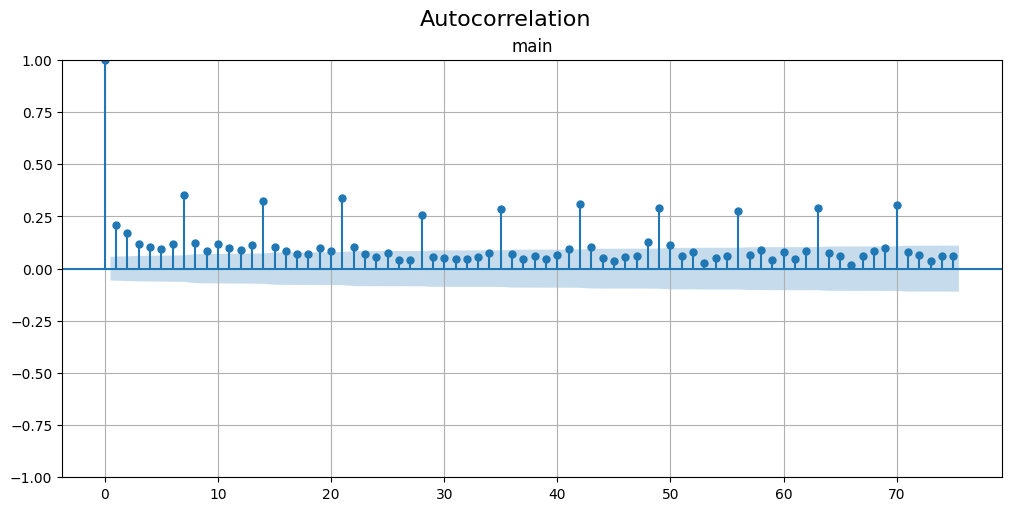

In [151]:
sample_acf_plot(ts_in, lags = 75)

Чётко прослеживается сезонность с периодом в одну неделю.

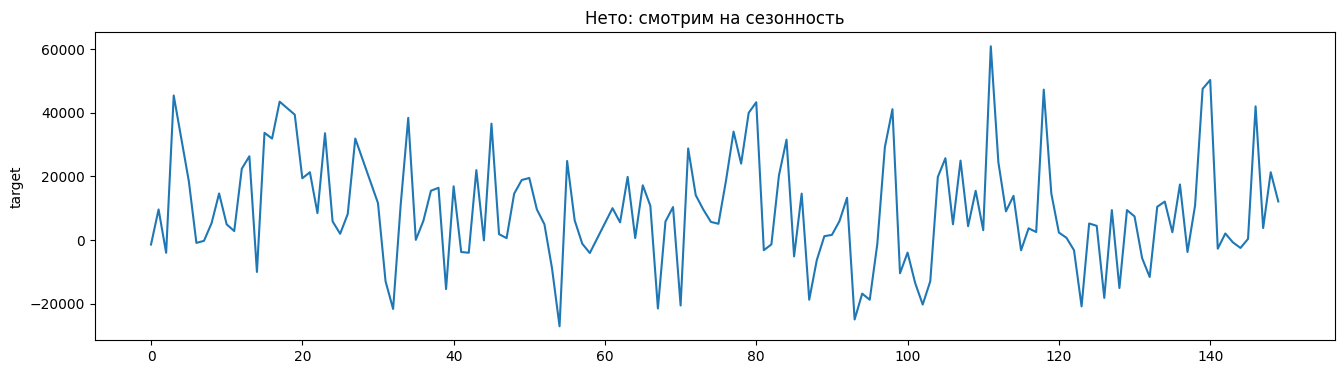

In [69]:
plt.figure(figsize=(16, 4))
plt.title('Нето: смотрим на сезонность')
sns.lineplot(np.arange(150),df['target'][:150])  
plt.show()

In [152]:
df_out = df.copy()
df_out["timestamp"] = pd.to_datetime(df_out["Date"])
df_out["segment"] = "main"
df_out.drop(columns=["target", "CashIn"], inplace=True)
df_out["target"] = df_out["CashOut"]
df_out.drop(columns=["CashOut"], inplace=True)
df_out = TSDataset.to_dataset(df_out)
ts_out = TSDataset(df_out, freq="D")
ts_out.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 1
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2016-01-05    2019-03-31    1182           88


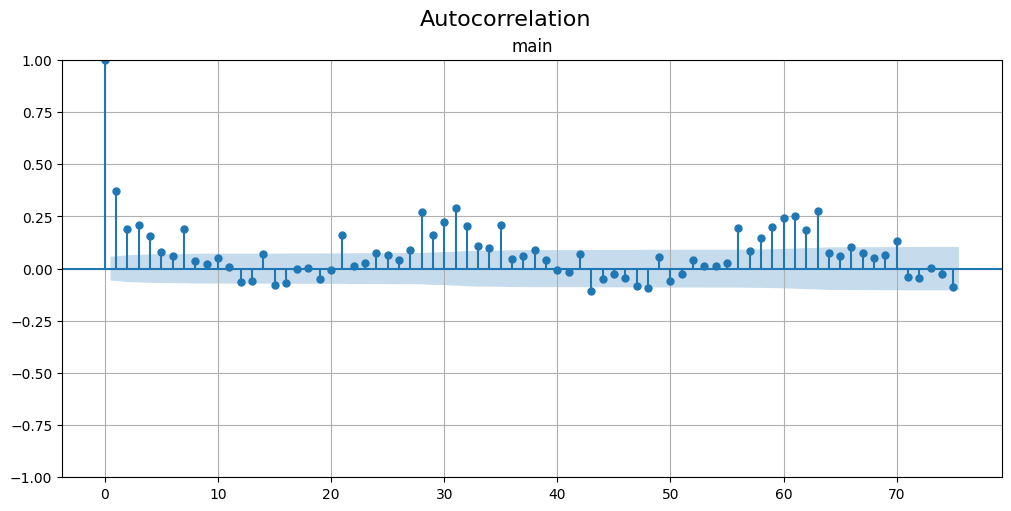

In [155]:
sample_acf_plot(ts_out, lags = 75)

Прослеживается сезонность с периодом в один месяц (30 дней)

Построим сетку скаттерплотов (референс - семинар: https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem07_ts2/sem07_ts2.ipynb)

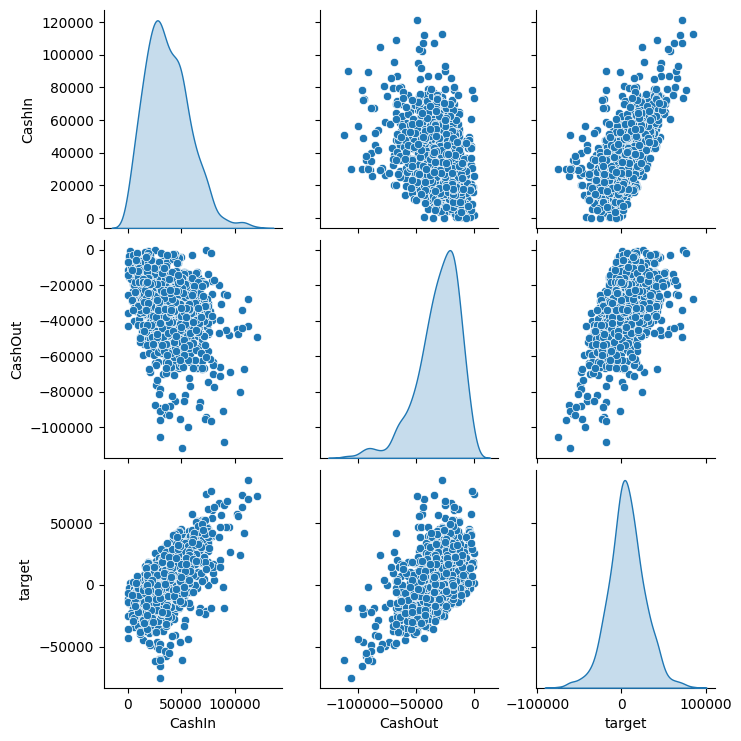

In [243]:
sns.pairplot(df, diag_kind="kde")

Отрицательная зависмость наблюдается между CashIn и CashOut, что логично. Зависимость между target и CashIn и CashOut попарно положительна. Судя по графикам алотности, target имеет распределение, близкое к нормальному, а CashIn и CashOut имеют скошенные распределения.

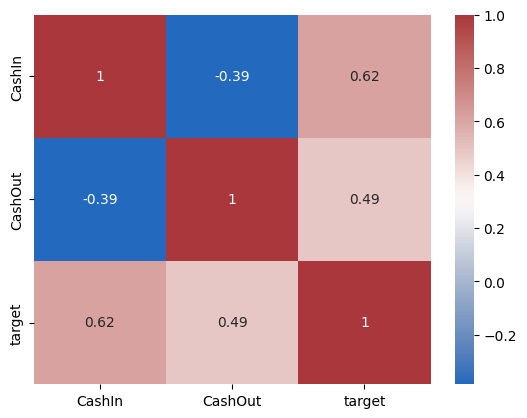

In [267]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

Референс: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html

In [500]:
multi_data = pd.melt(df, id_vars=['Date'], value_vars=['CashIn', 'CashOut', 'target'],
       var_name='segment', value_name='target')
multi_data

Date segment   target
0      1/5/2016  CashIn  20840.0
1      1/6/2016  CashIn  28460.0
2      1/7/2016  CashIn  19250.0
3      1/8/2016  CashIn  49770.0
4      1/9/2016  CashIn      NaN
...         ...     ...      ...
3541  3/27/2019  target  -3440.0
3542  3/28/2019  target  16640.0
3543  3/29/2019  target  44310.0
3544  3/30/2019  target  -5100.0
3545  3/31/2019  target  32470.0

[3546 rows x 3 columns]

In [501]:
multi_data["timestamp"] = pd.to_datetime(multi_data["Date"])
del multi_data["Date"]
multi_data2 = TSDataset.to_dataset(multi_data)
ts_multi = TSDataset(multi_data2, freq="D")
ts_multi.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashIn        2016-01-05    2019-03-31    1182          101
CashOut       2016-01-05    2019-03-31    1182           88
target        2016-01-05    2019-03-31    1182          110


### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [248]:
from etna.analysis import plot_imputation
from etna.transforms import TimeSeriesImputerTransform
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.transforms import MedianOutliersTransform

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

Референс по предобработке рядов: https://habr.com/ru/companies/tinkoff/articles/677186/

Также воспользуемся блокнотом с семинара: https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem06_ts1/sem06_ts1.ipynb

Для заполнения пропусков воспользуемся методом скользящего среднего, поскольку наши данные достаточно высокочастотные (дневные) и обладают коротким периодом сезонности (неделя). А значит, важно учитывать значения соседних наблюдений. Таким образом, скользящее среднее подойдёт лучше, чем плотностный метод, берущий в расёт всё распределение.

Попробуем применить разную длину окна для скользящего среднего и оценим адекватность заполнения по графикам. Разведывательный анализ показал, что в двух рядах период сезонности равен 1 неделе и в ещё одном - меясц. Соответсвенно, попробуем длины окна 30, 14 и 7 дней.

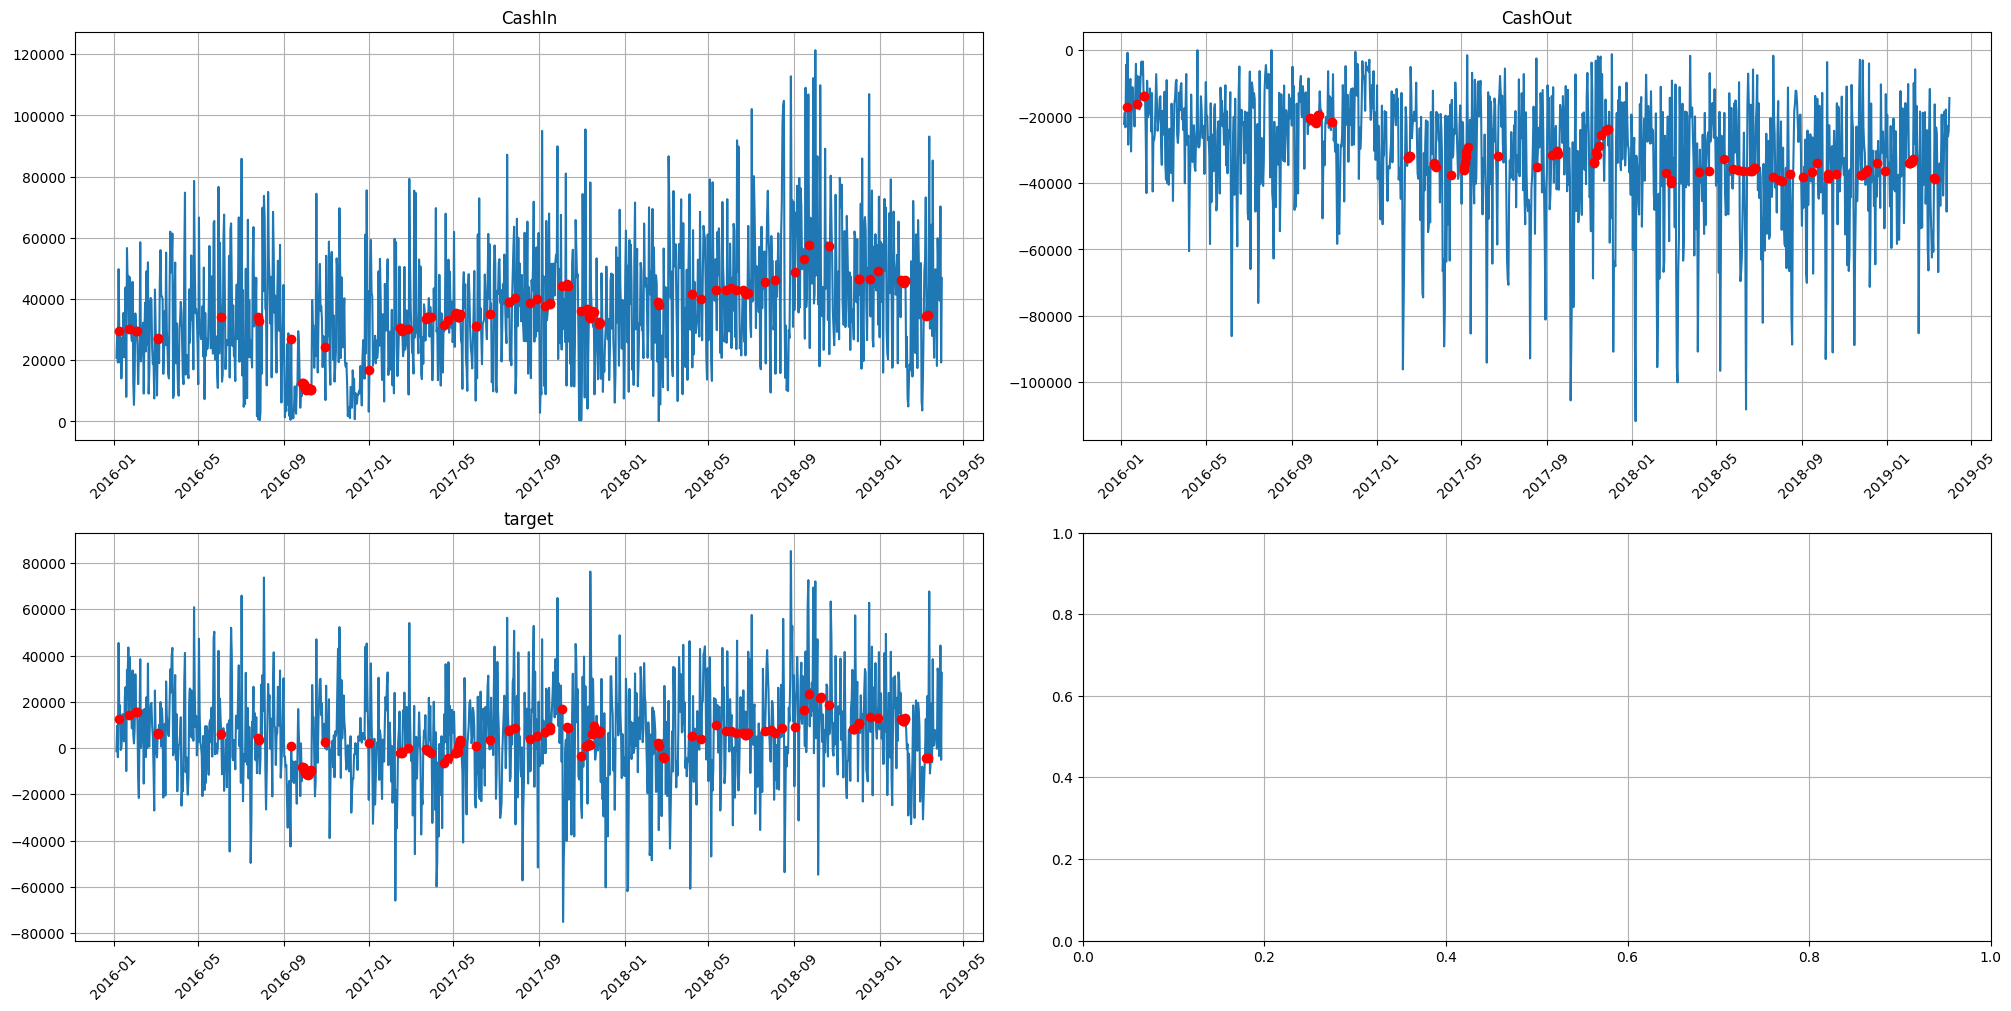

In [249]:
imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
plot_imputation(ts_multi, imputer)

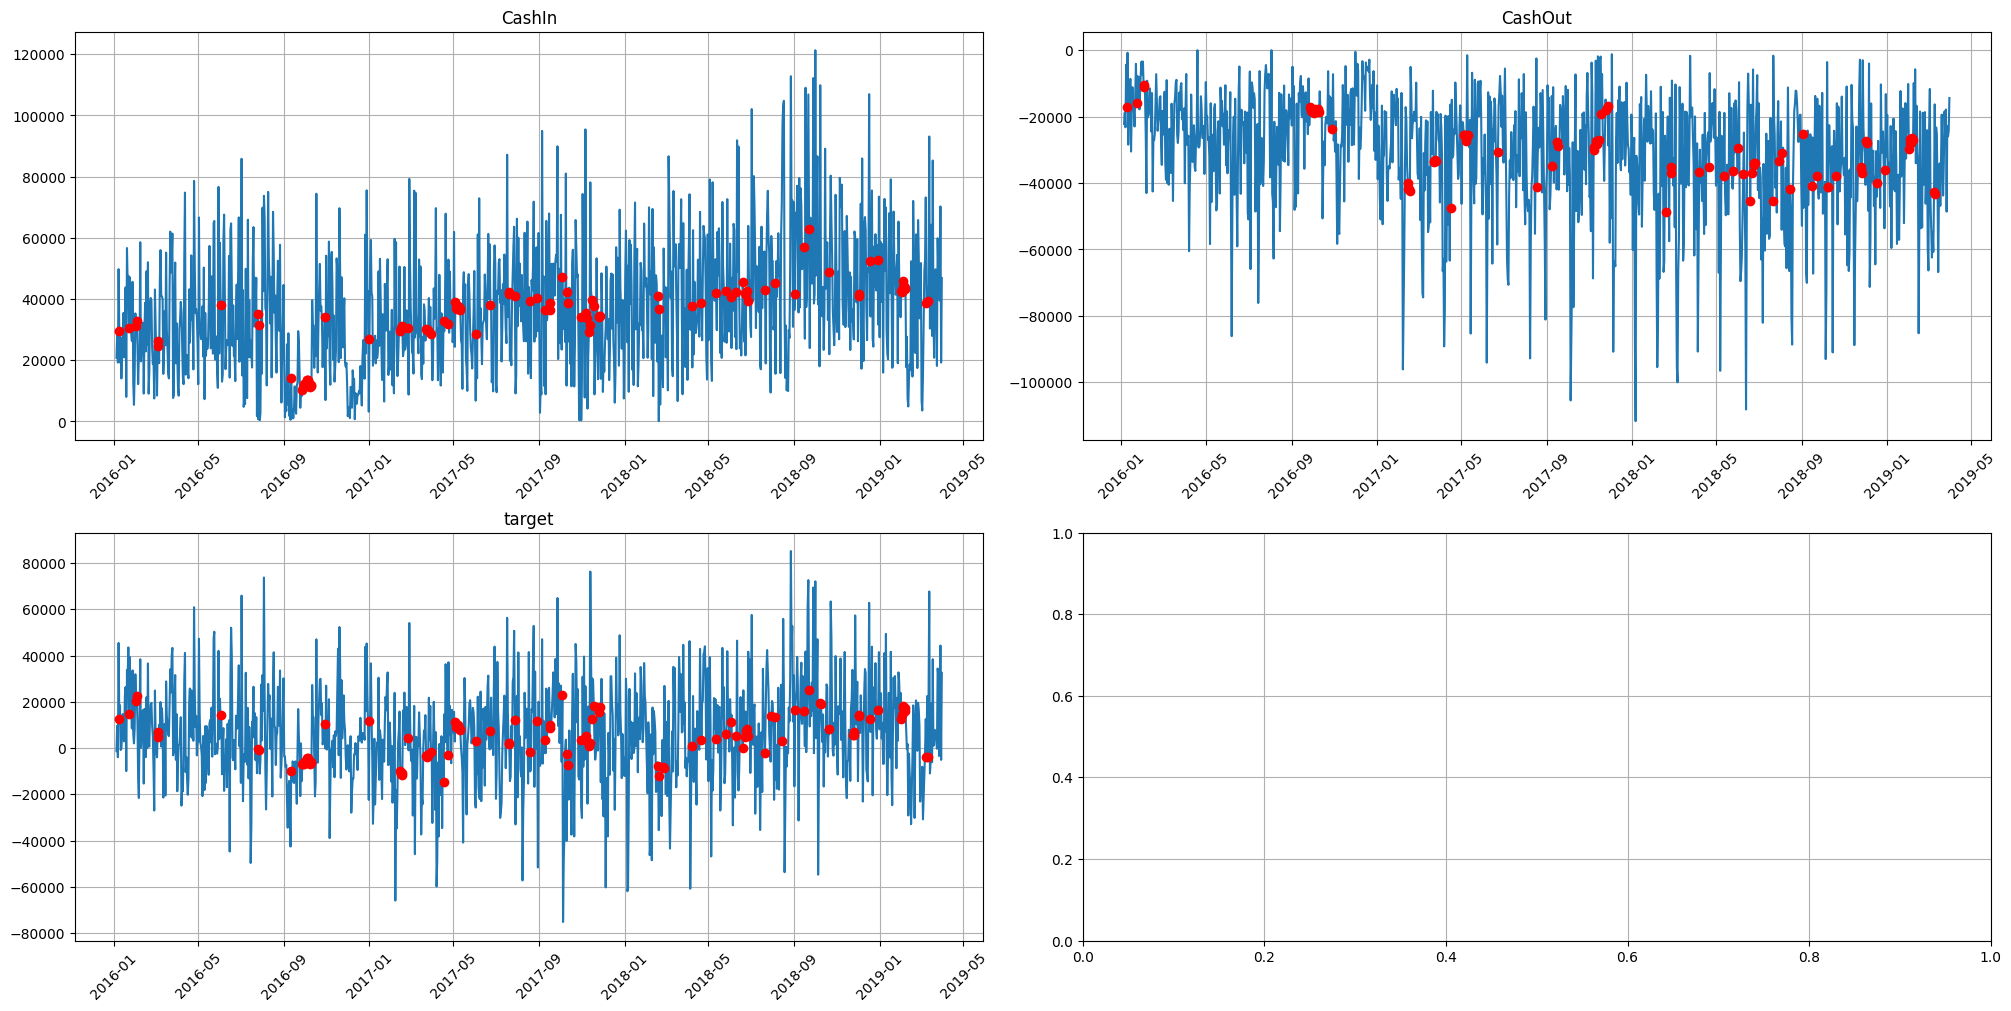

In [250]:
imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=14)
plot_imputation(ts_multi, imputer)

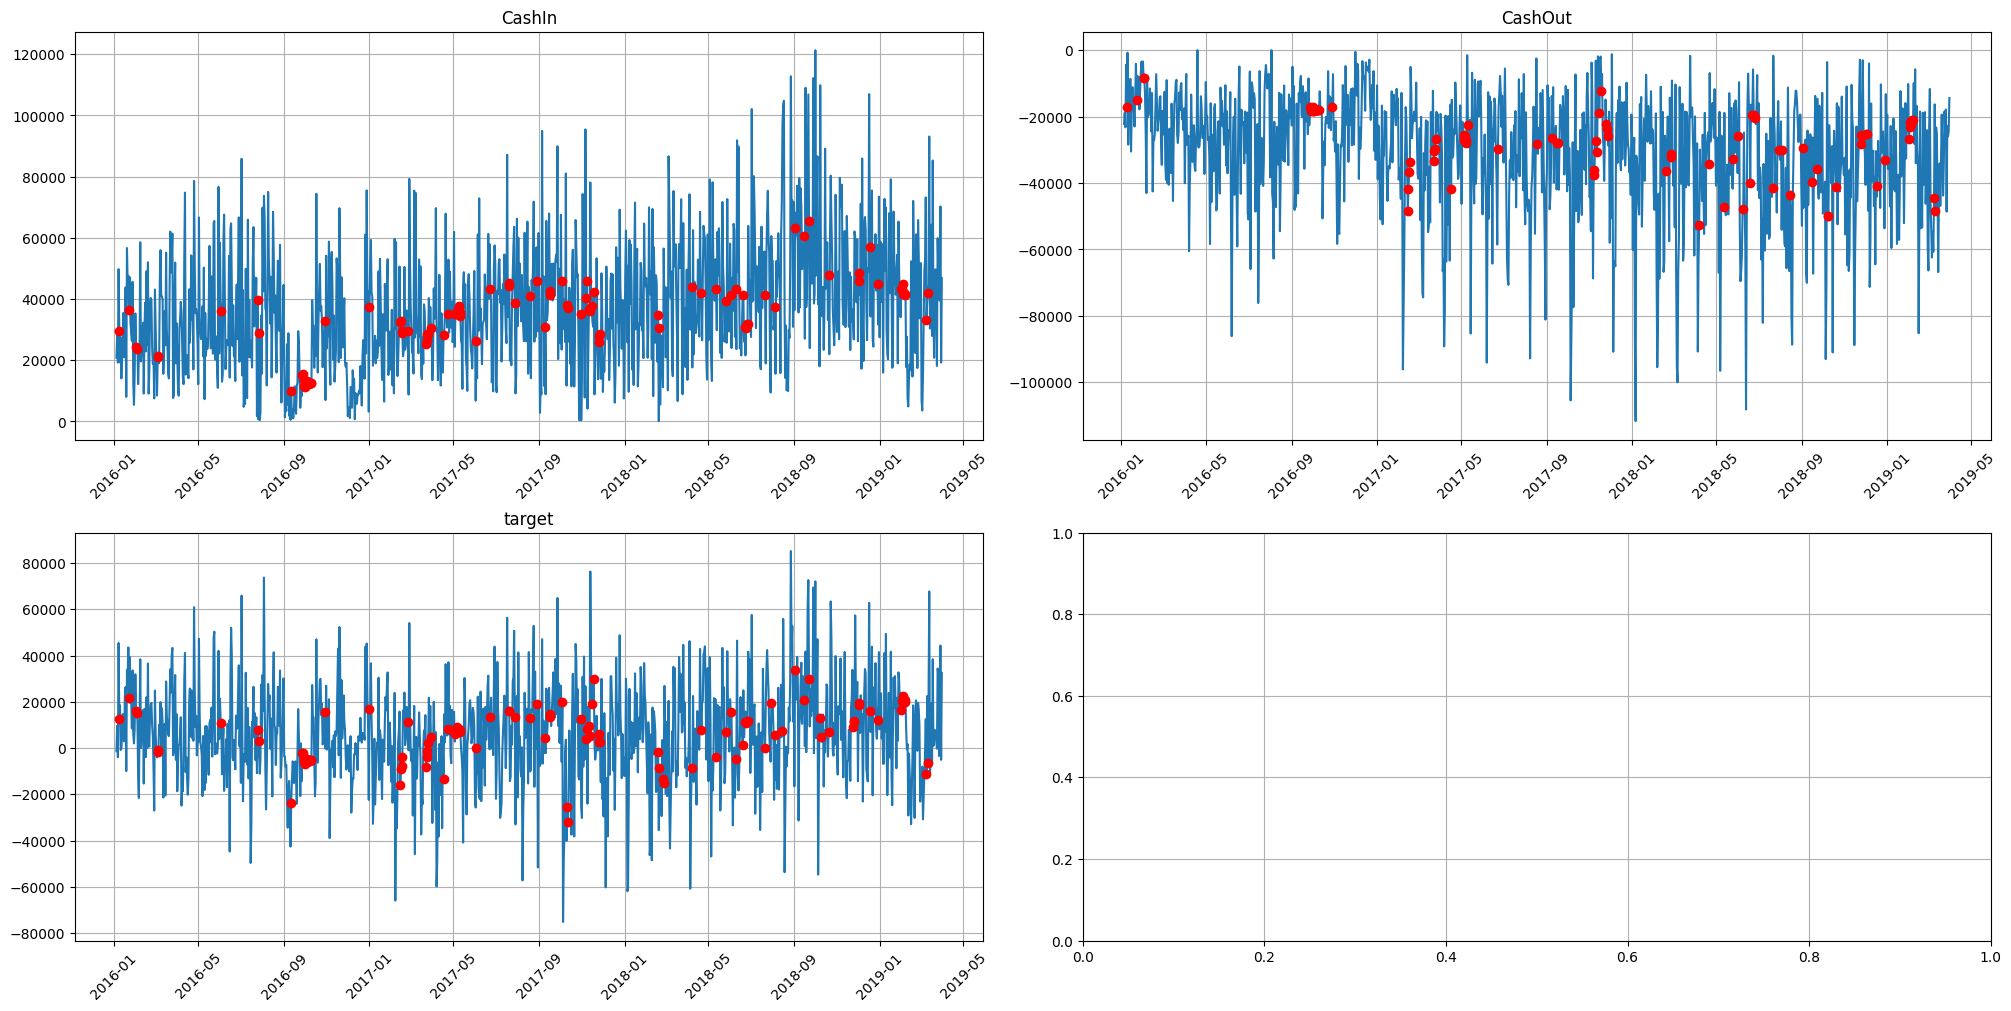

In [251]:
imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=7)
plot_imputation(ts_multi, imputer)

Видим, что результат примерно одинаков для каждого из трёх значений длины окна, однако при window=7 заполненнные значения сильно "скачут" - вероятно, такое заполнение завышает и занижает оценку пропущенных значений. При window=30 заполненные значения наоборот обладают очень маленьким разбросом.

window=14 выглядит наиболее правдоподобно, такой параметр и выберем.

Перейдём к поиску аномалий. Из тех же соображений, по которым выбирали метод для заполнения пропусков, выберем метод, использующий медиану. + мединана - устойчивый к выбросам показатель.

In [185]:
segment = "target"
method = get_anomalies_median
params_bounds = {"window_size": (10, 70, 1), "alpha": (0.1, 4, 0.25)}

In [186]:
plot_anomalies_interactive(
    ts=ts_multi, segment=segment, method=method, params_bounds=params_bounds
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='window_size', max=70, min=10, …

Подбираем оптимальные параметры, основываясь на визуализации: хотим, чтобы выбросы корректировались правдоподобно, но с некоторым естественным для ряда разбросом.

In [253]:
best_params = {"window_size": 12, "alpha": 1.85}

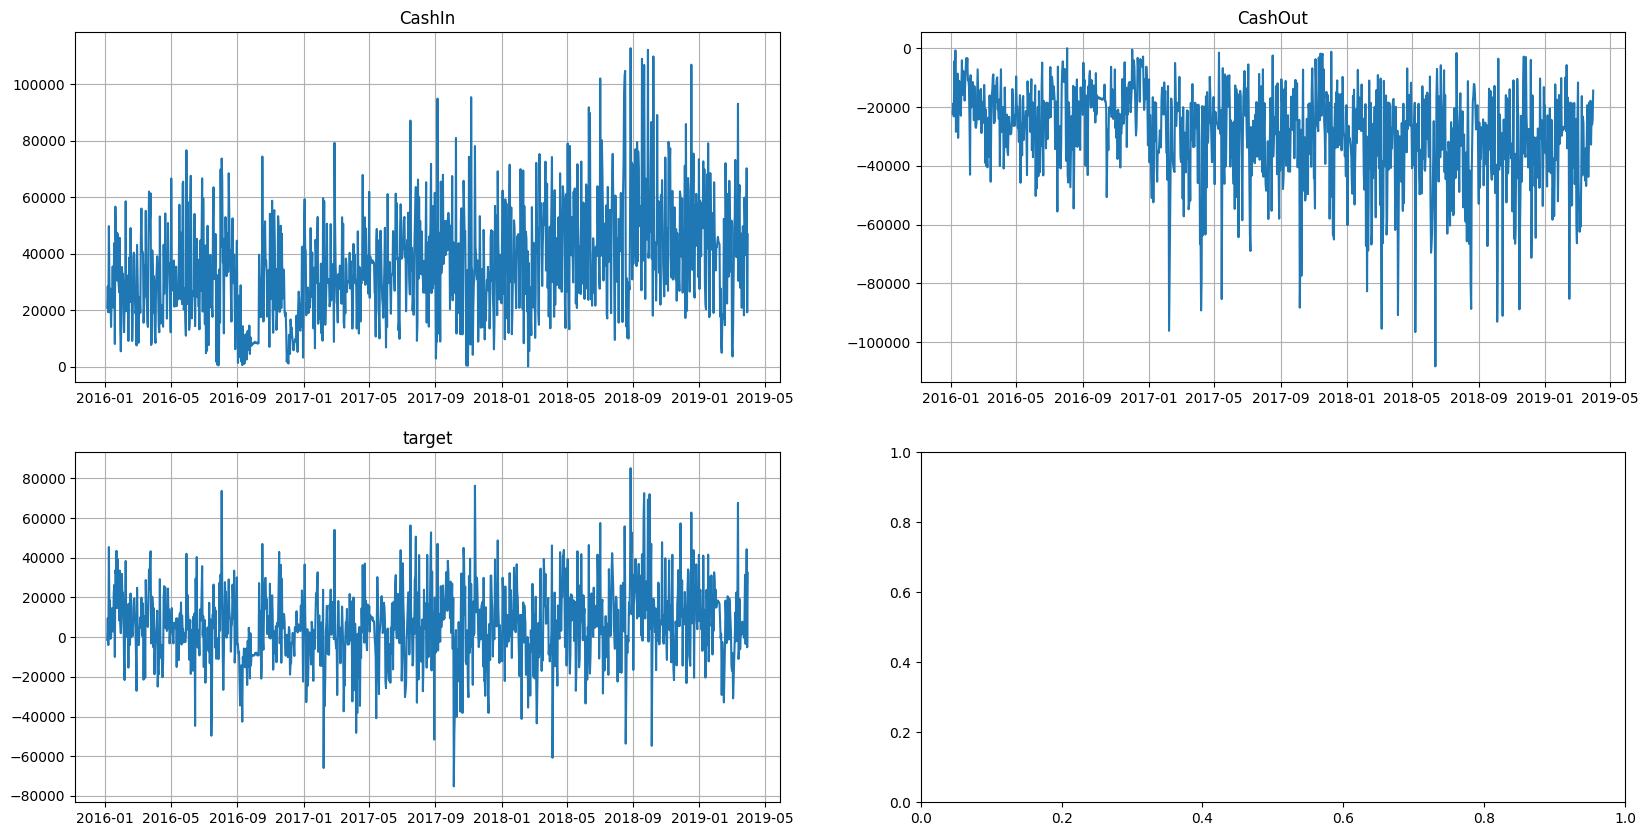

In [502]:
# Impute outliers with NaNs
outliers_remover = MedianOutliersTransform(in_column="target", **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=14
)
ts_multi.fit_transform([outliers_remover, outliers_imputer]) # применяем заполнение пропусков и обработку выбросов
ts_multi.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [479]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE, MAPE, MSE
from etna.analysis import plot_backtest

In [235]:
HORIZON = 5

In [194]:
df[len(df)-5:]

Date   CashIn  CashOut   target
1181  3/27/2019  45160.0 -48600.0  -3440.0
1182  3/28/2019  39480.0 -22840.0  16640.0
1183  3/29/2019  70260.0 -25950.0  44310.0
1184  3/30/2019  19250.0 -24350.0  -5100.0
1185  3/31/2019  46870.0 -14400.0  32470.0

In [195]:
df.head()

Date   CashIn  CashOut   target
4  1/5/2016  20840.0 -22200.0  -1360.0
5  1/6/2016  28460.0 -18810.0   9650.0
6  1/7/2016  19250.0 -23210.0  -3960.0
7  1/8/2016  49770.0  -4350.0  45420.0
8  1/9/2016      NaN      NaN      NaN

In [503]:
train_ts, test_ts = ts_multi.train_test_split(
    train_start="2016-05-01",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

Основываясь на разведке в 1-ом задании, ставим weekly_seasonality=True.

In [256]:
smape = SMAPE()

model = ProphetModel(weekly_seasonality=True)
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['target']:.2f}")

10:12:23 - cmdstanpy - INFO - Chain [1] start processing
10:12:23 - cmdstanpy - INFO - Chain [1] done processing
10:12:23 - cmdstanpy - INFO - Chain [1] start processing
10:12:23 - cmdstanpy - INFO - Chain [1] done processing
10:12:24 - cmdstanpy - INFO - Chain [1] start processing
10:12:24 - cmdstanpy - INFO - Chain [1] done processing


139.39


In [257]:
smape = SMAPE()

model = ProphetModel(weekly_seasonality=True)
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['CashIn']:.2f}")

10:12:36 - cmdstanpy - INFO - Chain [1] start processing
10:12:36 - cmdstanpy - INFO - Chain [1] done processing
10:12:36 - cmdstanpy - INFO - Chain [1] start processing
10:12:36 - cmdstanpy - INFO - Chain [1] done processing
10:12:37 - cmdstanpy - INFO - Chain [1] start processing
10:12:37 - cmdstanpy - INFO - Chain [1] done processing


37.62


In [259]:
smape = SMAPE()

model = ProphetModel(weekly_seasonality=True)
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['CashOut']:.2f}")

10:13:12 - cmdstanpy - INFO - Chain [1] start processing
10:13:13 - cmdstanpy - INFO - Chain [1] done processing
10:13:13 - cmdstanpy - INFO - Chain [1] start processing
10:13:13 - cmdstanpy - INFO - Chain [1] done processing
10:13:13 - cmdstanpy - INFO - Chain [1] start processing
10:13:13 - cmdstanpy - INFO - Chain [1] done processing


58.24


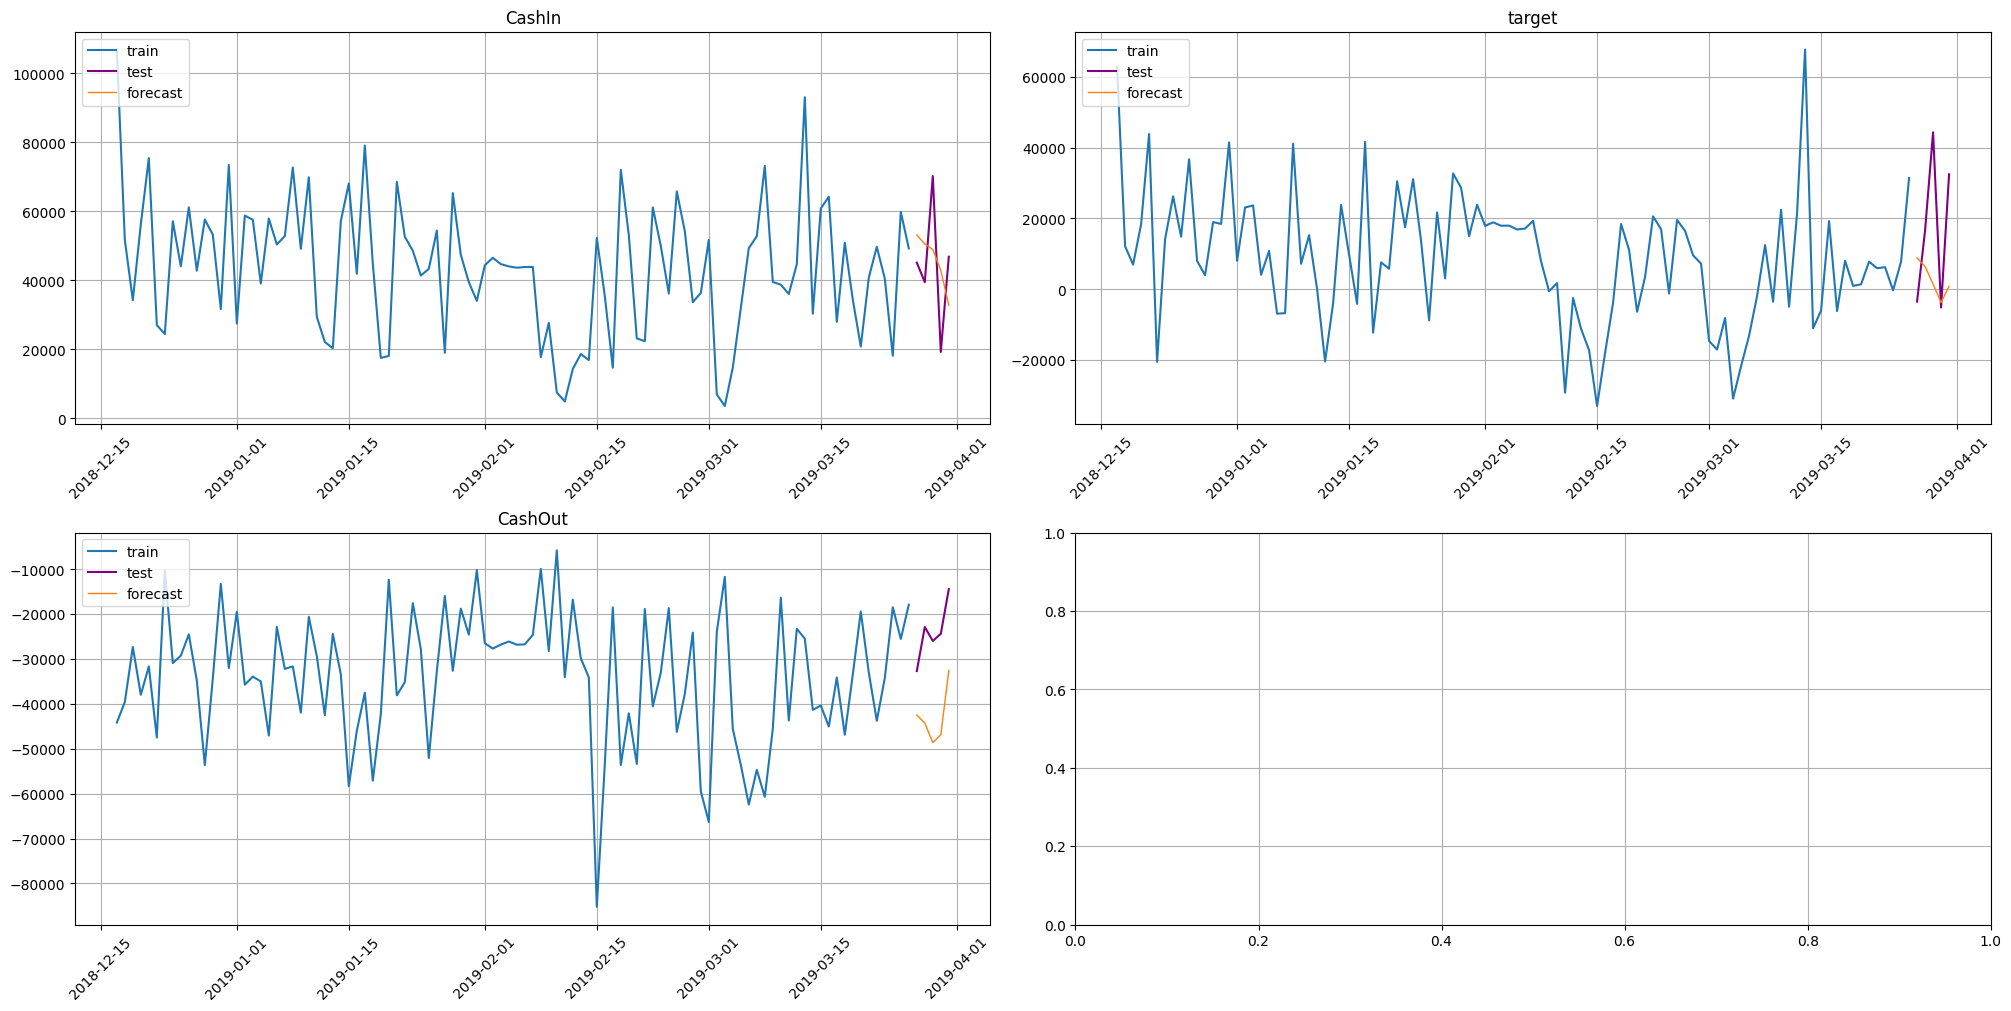

In [261]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Лучше всего предсказывать на основе CashIn (минимальное их трёх значение SMAPE)

In [262]:
mae = MAE()

model = ProphetModel(weekly_seasonality=True)
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

print(f"{mae(y_true=test_ts, y_pred=forecast_ts)['target']:.2f}")

10:13:49 - cmdstanpy - INFO - Chain [1] start processing
10:13:49 - cmdstanpy - INFO - Chain [1] done processing
10:13:49 - cmdstanpy - INFO - Chain [1] start processing
10:13:49 - cmdstanpy - INFO - Chain [1] done processing
10:13:50 - cmdstanpy - INFO - Chain [1] start processing
10:13:50 - cmdstanpy - INFO - Chain [1] done processing


19666.04


In [263]:
mae = MAE()

model = ProphetModel(weekly_seasonality=True)
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

print(f"{mae(y_true=test_ts, y_pred=forecast_ts)['CashIn']:.2f}")

10:14:49 - cmdstanpy - INFO - Chain [1] start processing
10:14:49 - cmdstanpy - INFO - Chain [1] done processing
10:14:49 - cmdstanpy - INFO - Chain [1] start processing
10:14:50 - cmdstanpy - INFO - Chain [1] done processing
10:14:50 - cmdstanpy - INFO - Chain [1] start processing
10:14:50 - cmdstanpy - INFO - Chain [1] done processing


15624.37


In [264]:
mae = MAE()

model = ProphetModel(weekly_seasonality=True)
model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

print(f"{mae(y_true=test_ts, y_pred=forecast_ts)['CashOut']:.2f}")

10:15:09 - cmdstanpy - INFO - Chain [1] start processing
10:15:09 - cmdstanpy - INFO - Chain [1] done processing
10:15:10 - cmdstanpy - INFO - Chain [1] start processing
10:15:10 - cmdstanpy - INFO - Chain [1] done processing
10:15:10 - cmdstanpy - INFO - Chain [1] start processing
10:15:10 - cmdstanpy - INFO - Chain [1] done processing


18903.96


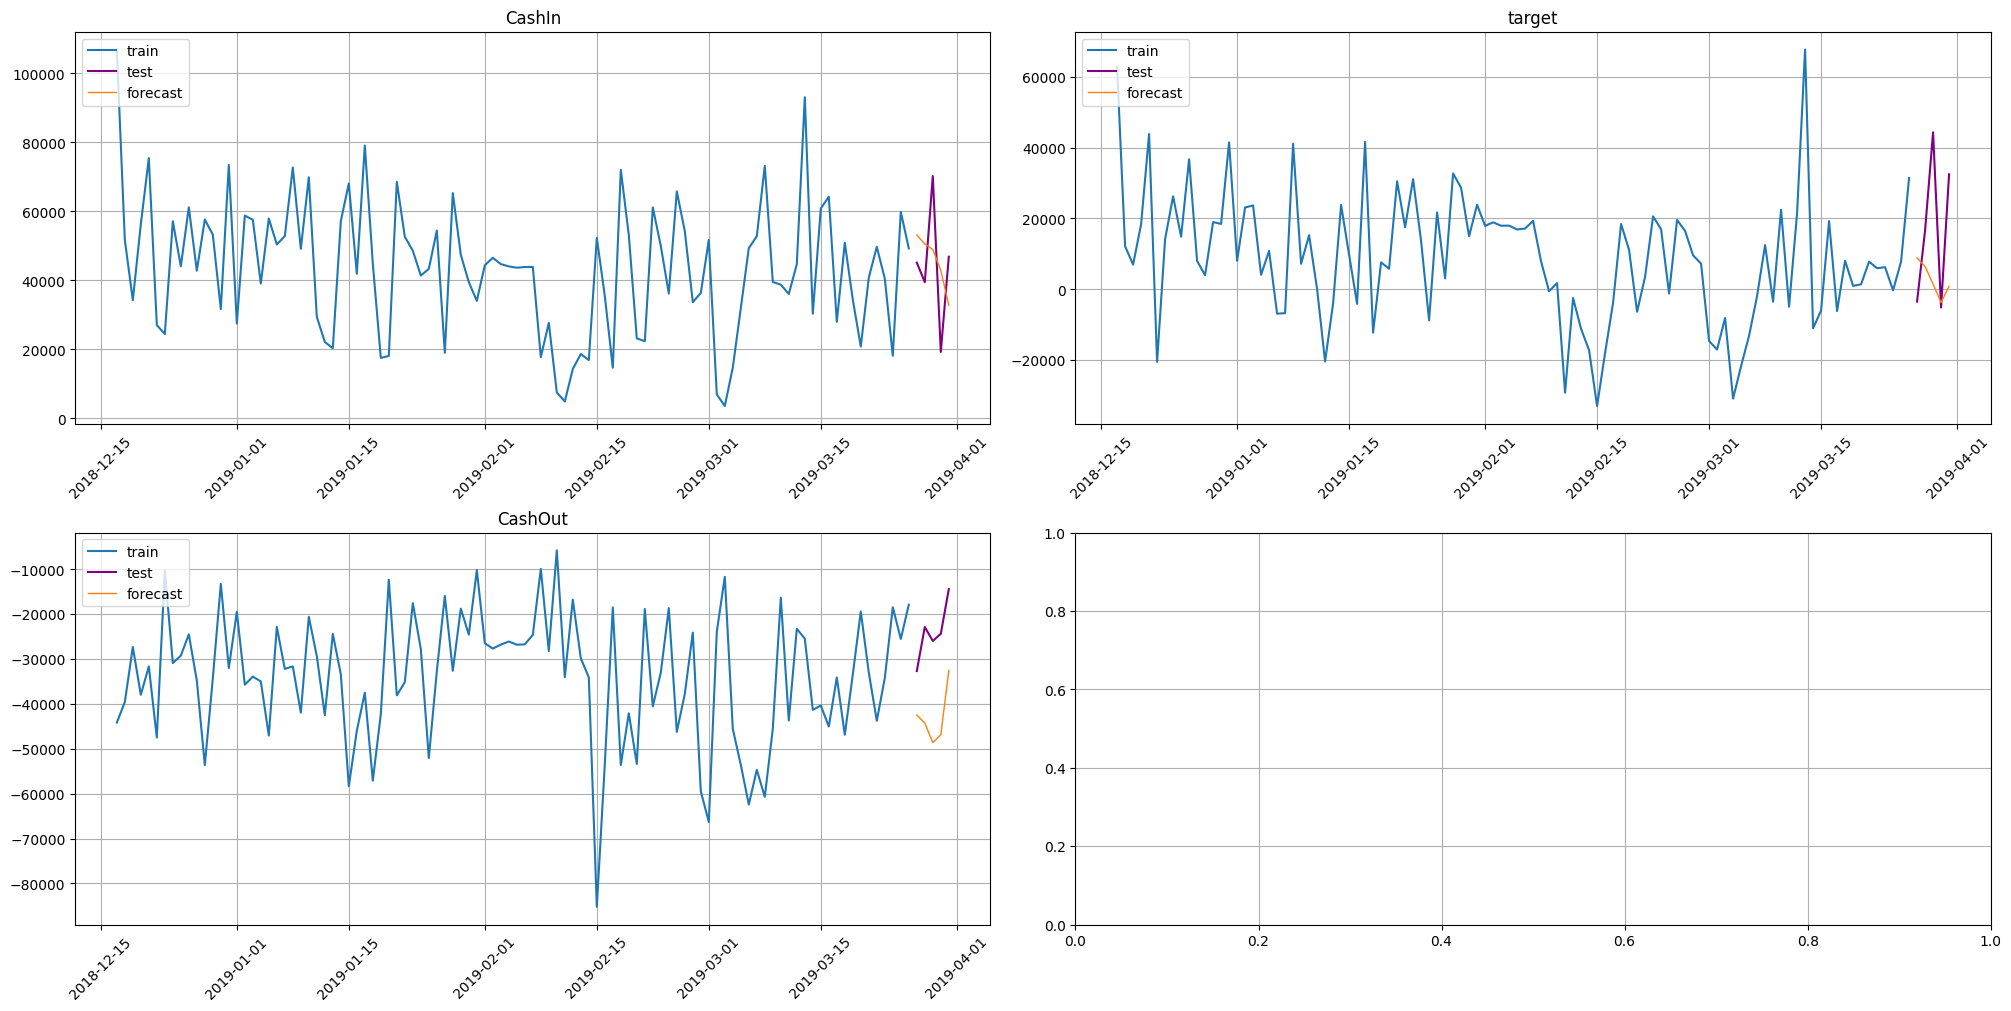

In [265]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=100)

Расчёт MAE даёт тот же результат: Лучше всего предсказывать на основе CashIn (минимальное их трёх значение MAE = 15624.37)

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [268]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [286]:
hierarchical_structure = HierarchicalStructure(
    level_structure={"netto": ["CashIn", "CashOut"]}, level_names=["netto", "cash_type"]
)

hierarchical_structure

HierarchicalStructure(level_structure = {'netto': ['CashIn', 'CashOut']}, level_names = ['netto', 'cash_type'], )

In [287]:
new_data = pd.DataFrame({'timestamp':multi_data['Date'].tolist(), 
                        'target':multi_data['target'].tolist(),
                        'segment': multi_data['segment'].tolist()})
new_data = new_data[(new_data['segment'] != 'target')]
new_data.head()

timestamp   target segment
0  1/5/2016  20840.0  CashIn
1  1/6/2016  28460.0  CashIn
2  1/7/2016  19250.0  CashIn
3  1/8/2016  49770.0  CashIn
4  1/9/2016      NaN  CashIn

In [288]:
hierarchical_df = TSDataset.to_dataset(df=new_data)

In [289]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [514]:
reconciliator = BottomUpReconciliator(target_level="netto", source_level="cash_type")

In [515]:
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]])

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

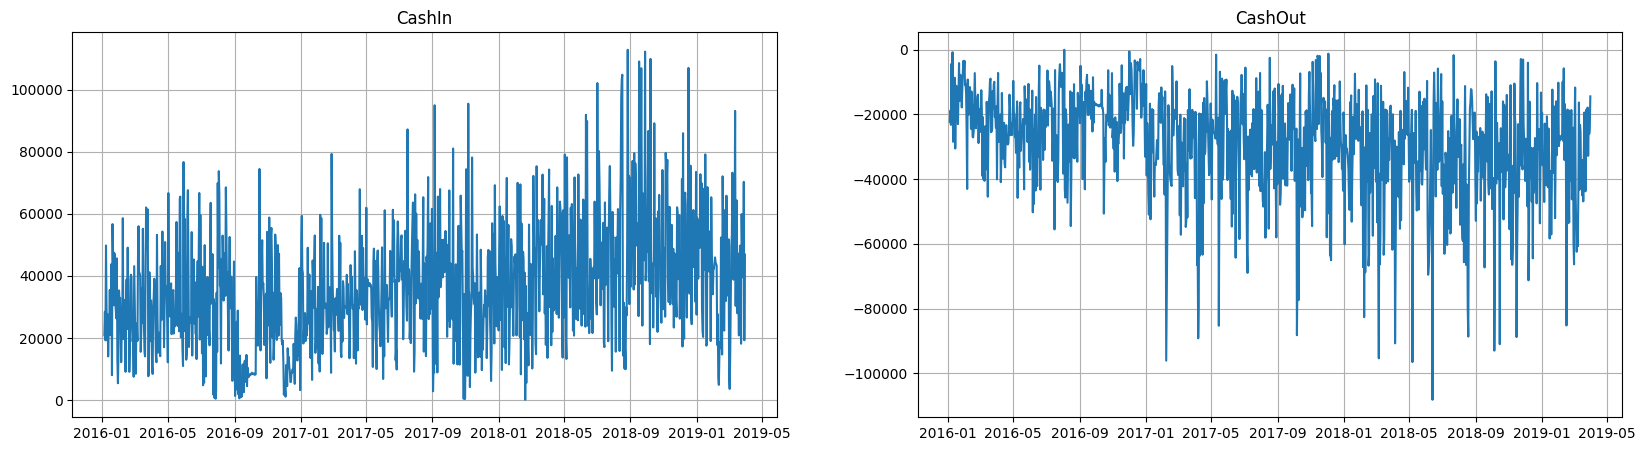

In [295]:
outliers_remover = MedianOutliersTransform(in_column="target", **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=14
)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer]) # применяем заполнение пропусков и обработку выбросов
hierarchical_ts.plot()

In [296]:
horizon = 5  # горизонт предсказаний
model = ProphetModel(weekly_seasonality=True)  # будем использовать Prophet

pipeline = Pipeline(model=model, horizon=horizon) 

In [302]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=hierarchical_ts, metrics=[MAE()], n_folds = 10
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
20:26:06 - cmdstanpy - INFO - Chain [1] start processing
20:26:06 - cmdstanpy - INFO - Chain [1] done processing
20:26:06 - cmdstanpy - INFO - Chain [1] start processing
20:26:06 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:13 - cmdstanpy - INFO - Chain [1] done processing
20:26:13 - cmdstanpy - INFO - Chain [1] start processing
20:26:13 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.7s remaining:    0.0s
2

In [304]:
metrics_df

segment           MAE  fold_number
0   CashIn  37649.338457            0
0   CashIn   9508.047082            1
0   CashIn  15583.734785            2
0   CashIn   9347.131993            3
0   CashIn  28441.173022            4
0   CashIn  11123.816417            5
0   CashIn  18904.233548            6
0   CashIn  22234.898592            7
0   CashIn   7721.785995            8
0   CashIn  15666.482659            9
1  CashOut  15406.808077            0
1  CashOut  14265.660243            1
1  CashOut  14227.585644            2
1  CashOut  12511.665400            3
1  CashOut  14483.070331            4
1  CashOut   8869.043781            5
1  CashOut   8654.412506            6
1  CashOut   9465.383321            7
1  CashOut  14137.922394            8
1  CashOut  17111.891025            9

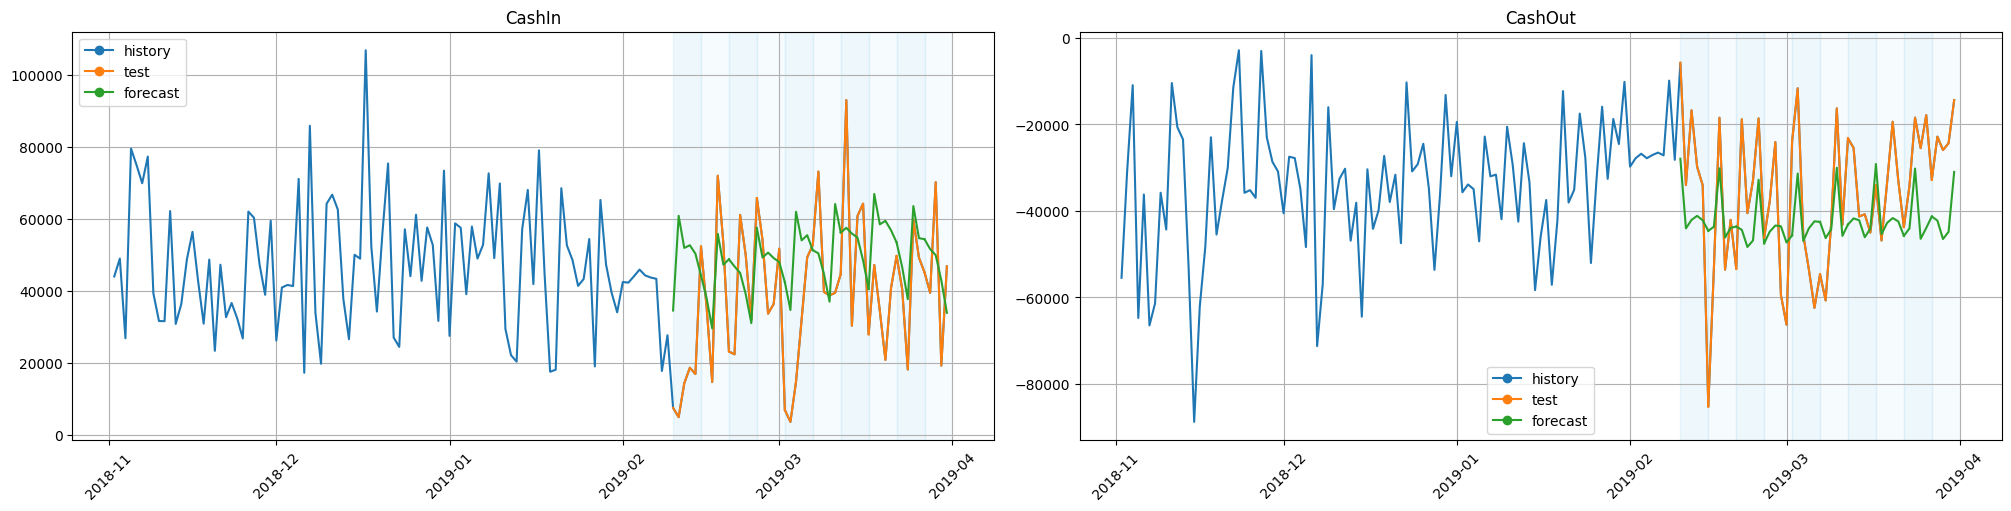

In [305]:
plot_backtest(forecast_df, hierarchical_ts, history_len=100)

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [443]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform, MeanTransform, DateFlagsTransform, LinearTrendTransform

## Модель ARIMA(p,q)

Как мы помним из первого пункта, наши ряды стационарны. Следовательно, на них можно строить ARIMA(p,q). Определим параметры лагов авторегрессии и скользящего среднего p и q. Рассмотрим график автокорреляционных функций:

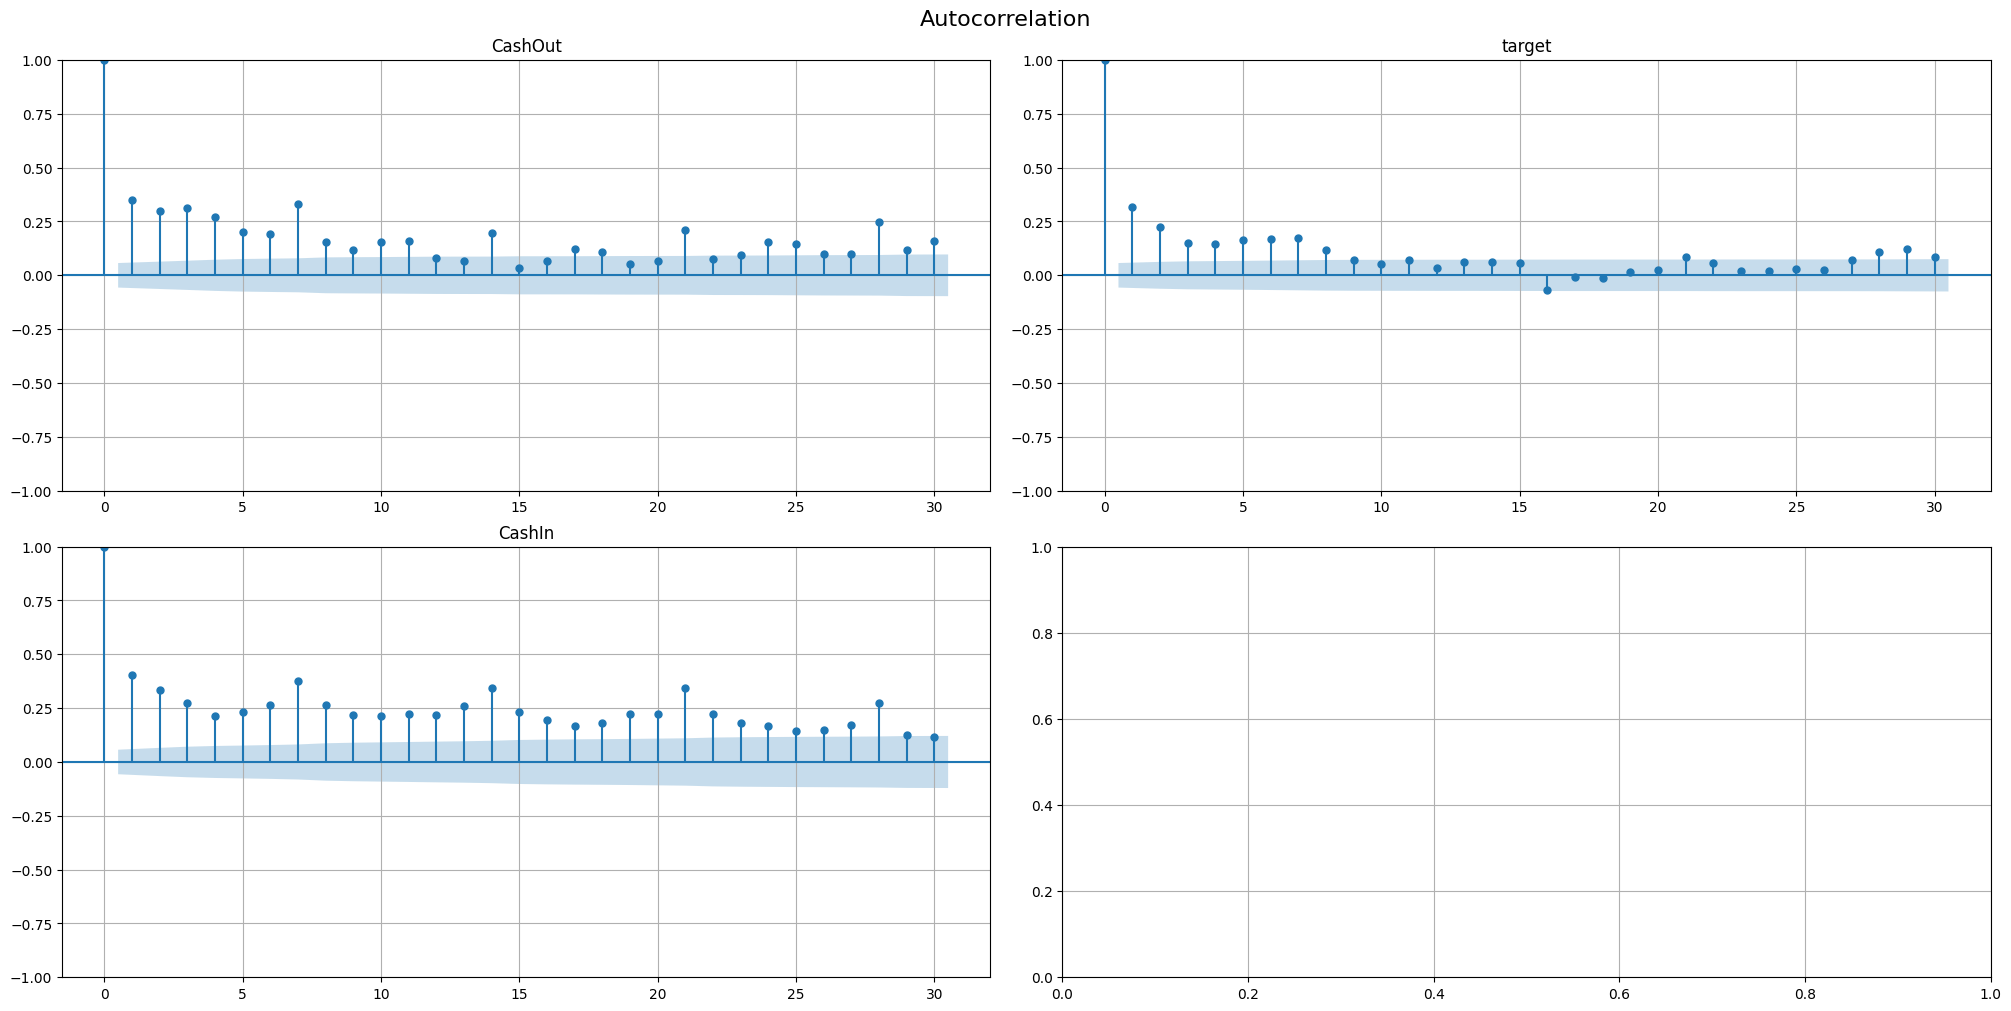

In [325]:
sample_acf_plot(ts_multi, lags = 30)

Для target значимы первые 9 лагов, для CashOut - первые 11 (и 14-ый). Для CashIn значимы первые 25 лагов, но отчётливо видно, что паттерн повторяется каждые 7-8 лагов, то есть каждую неделю.

Для избежания переобучения будем строить процесс авторегрессии на 14-ти лагах (для target и CashOut такого количества лагов хватит, а паттерн CashIn повтеряется с периодом неделя, 14 дней тоже для него подойдёт).

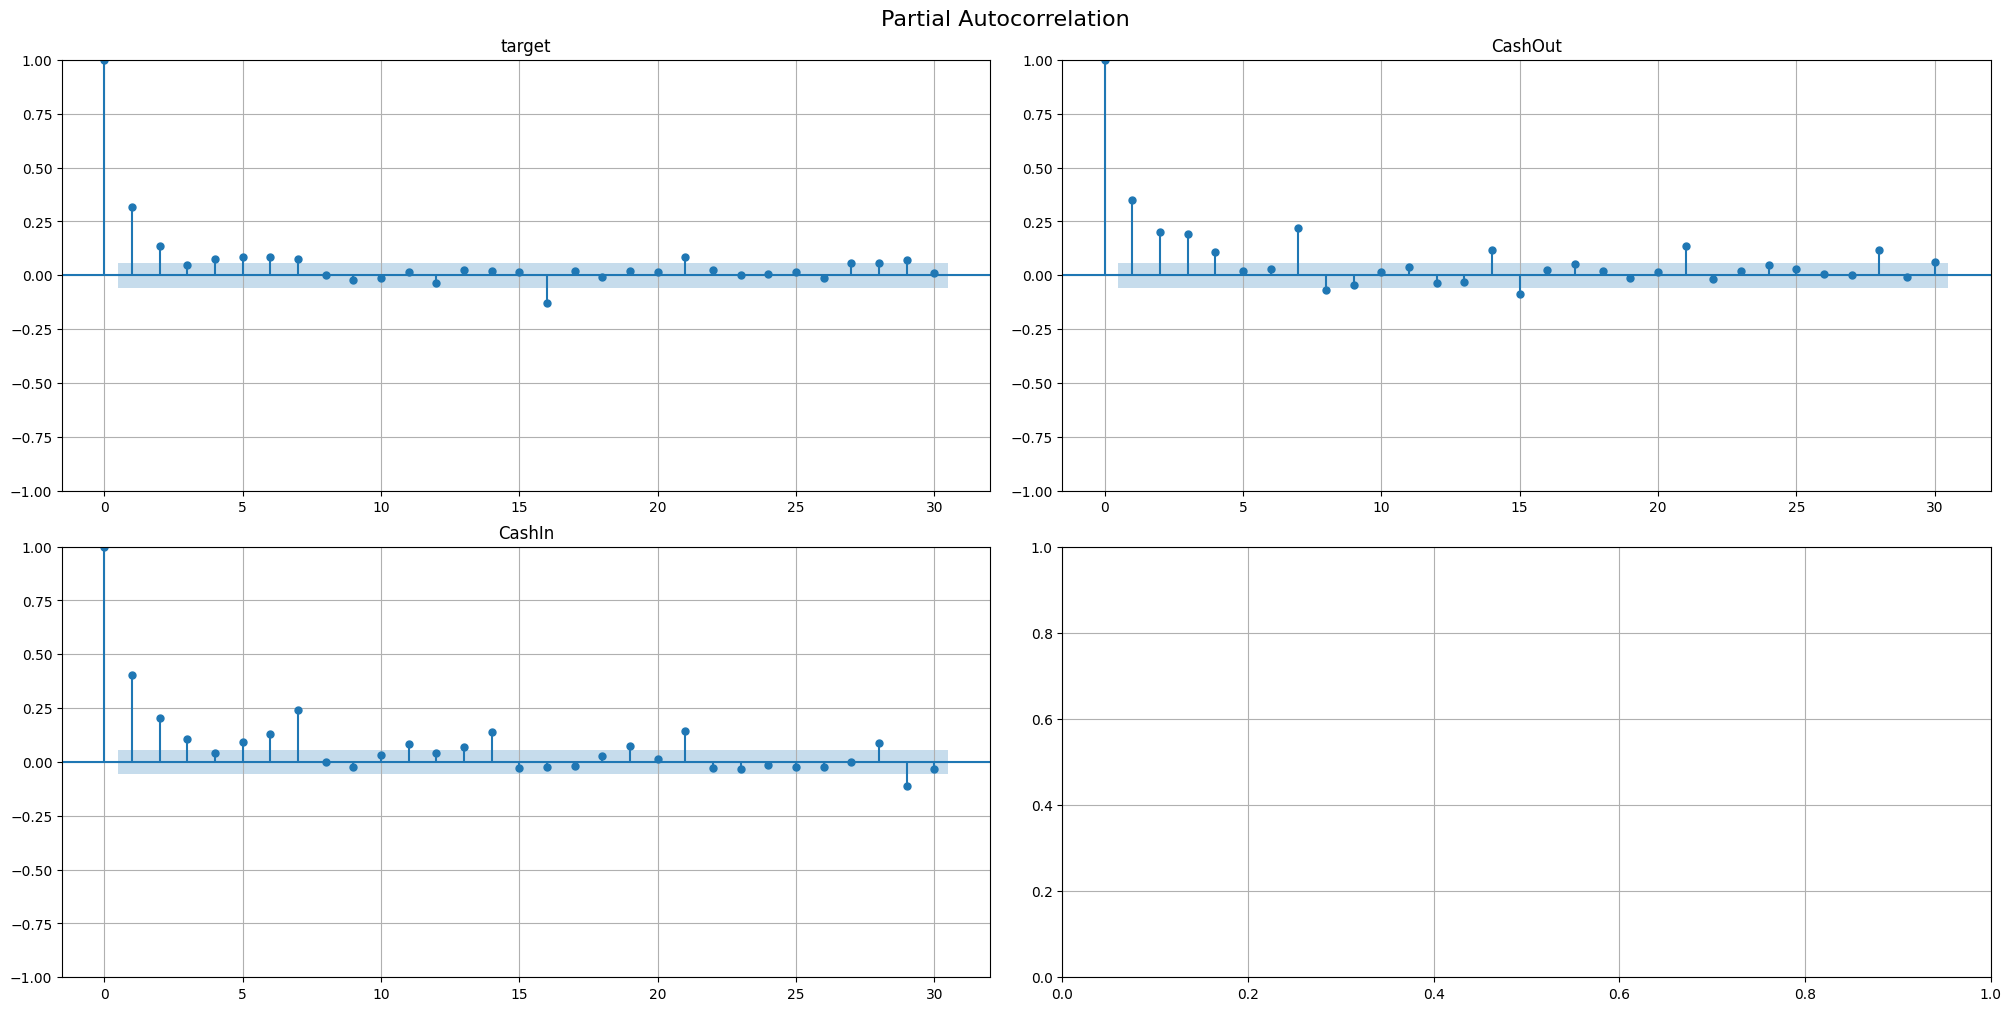

In [326]:
sample_pacf_plot(ts_multi, lags = 30)

Судя по графикам частичной автокорреляционной функции, строить процесс скользящего среднего разумно для 8-ми лагов.

Для преобразования рядов используем код с 6-го семинара: https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem06_ts1/sem06_ts1.ipynb

In [375]:
NUMBER_OF_LAGS = 14
lags14 = LagTransform(in_column="target", lags = [i for i in range(5,15)])
# в процессе обучения возникла ошибка, которая просила откинуть первые 5 лагов
mean8 = MeanTransform(in_column="target", window=8)

In [376]:
train_ts, test_ts = ts_multi.train_test_split(
    train_start="2016-05-01",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

In [377]:
train_ts_ARIMA = train_ts # создадим копию

In [378]:
train_ts_ARIMA.fit_transform([lags14, mean8])

In [379]:
HORIZON = 5

model = AutoARIMAModel()
model.fit(train_ts_ARIMA)
future_ts = train_ts_ARIMA.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'CashIn': 27.91788552615858,
 'target': 140.84136788074653,
 'CashOut': 34.751428216465065}

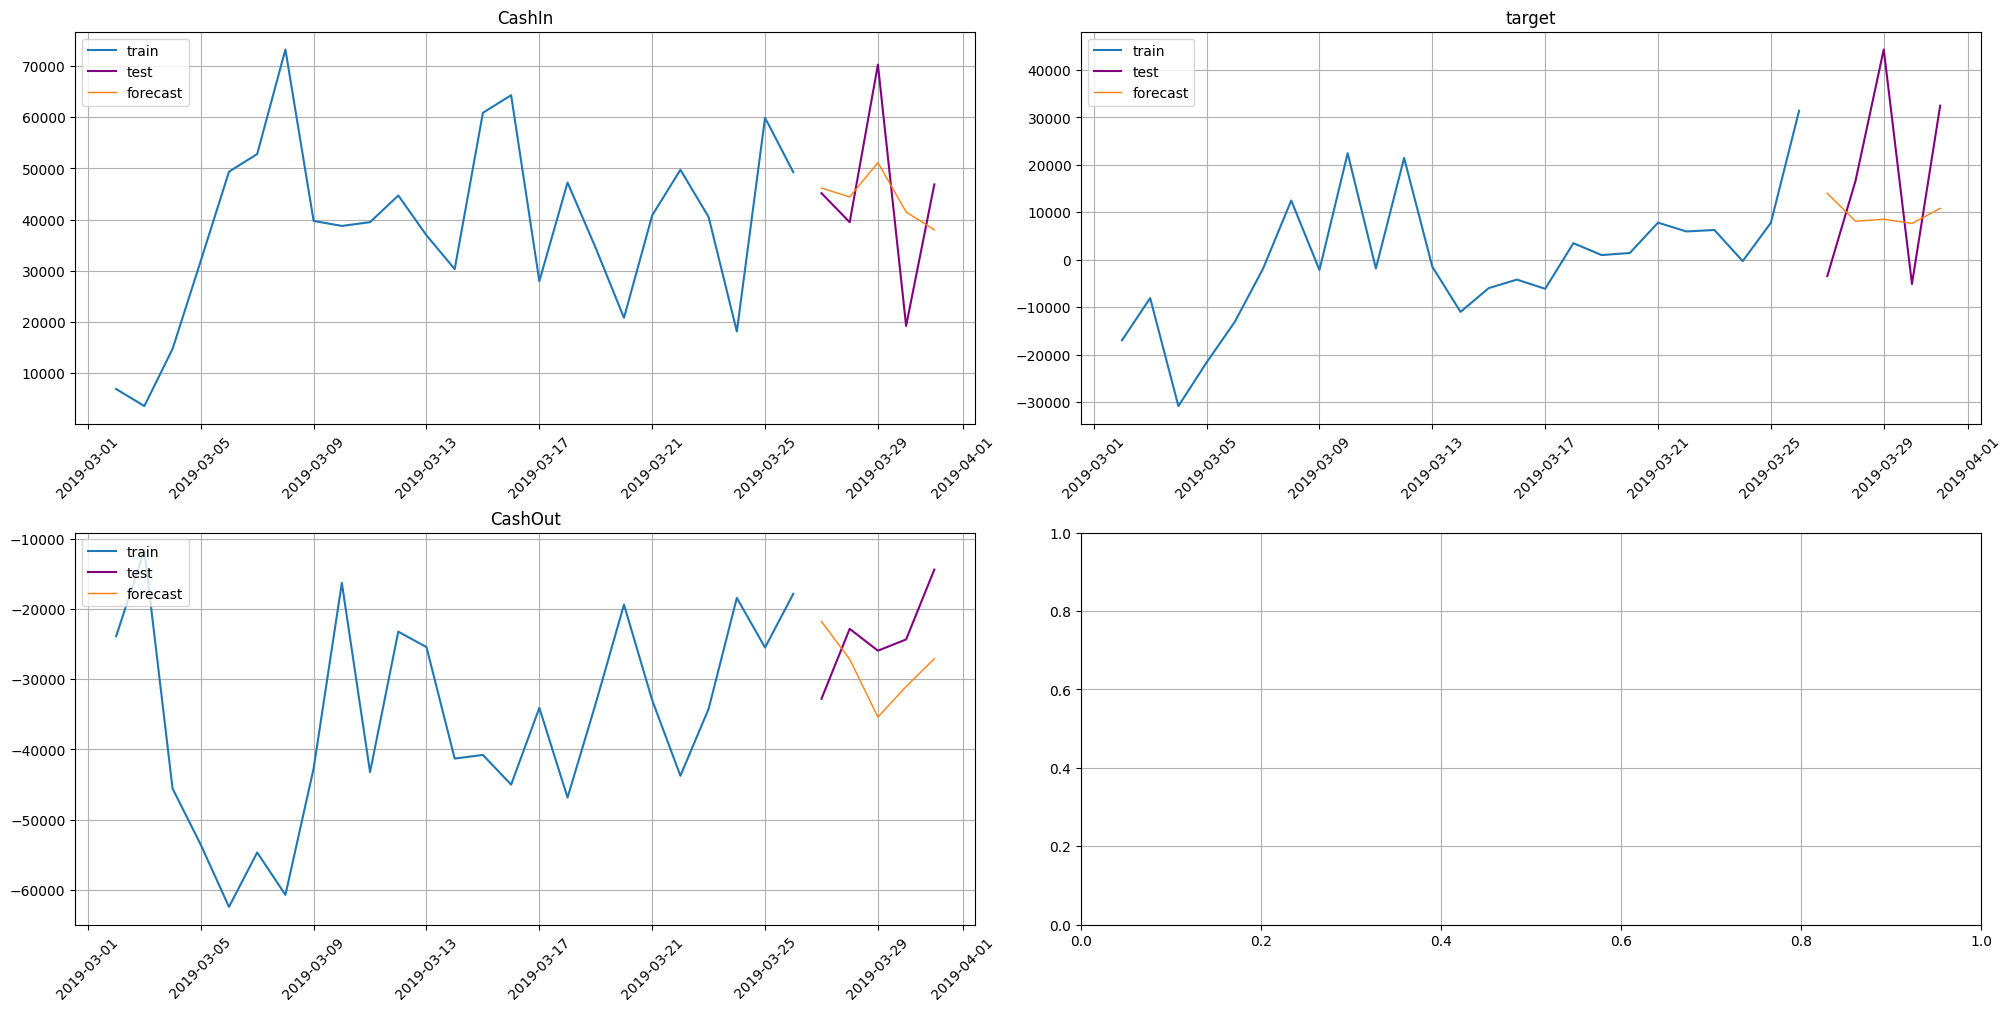

In [380]:
train_ts_ARIMA.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts_ARIMA, n_train_samples=25)

## Построение CatBoost

График для STL-декомпозиции:

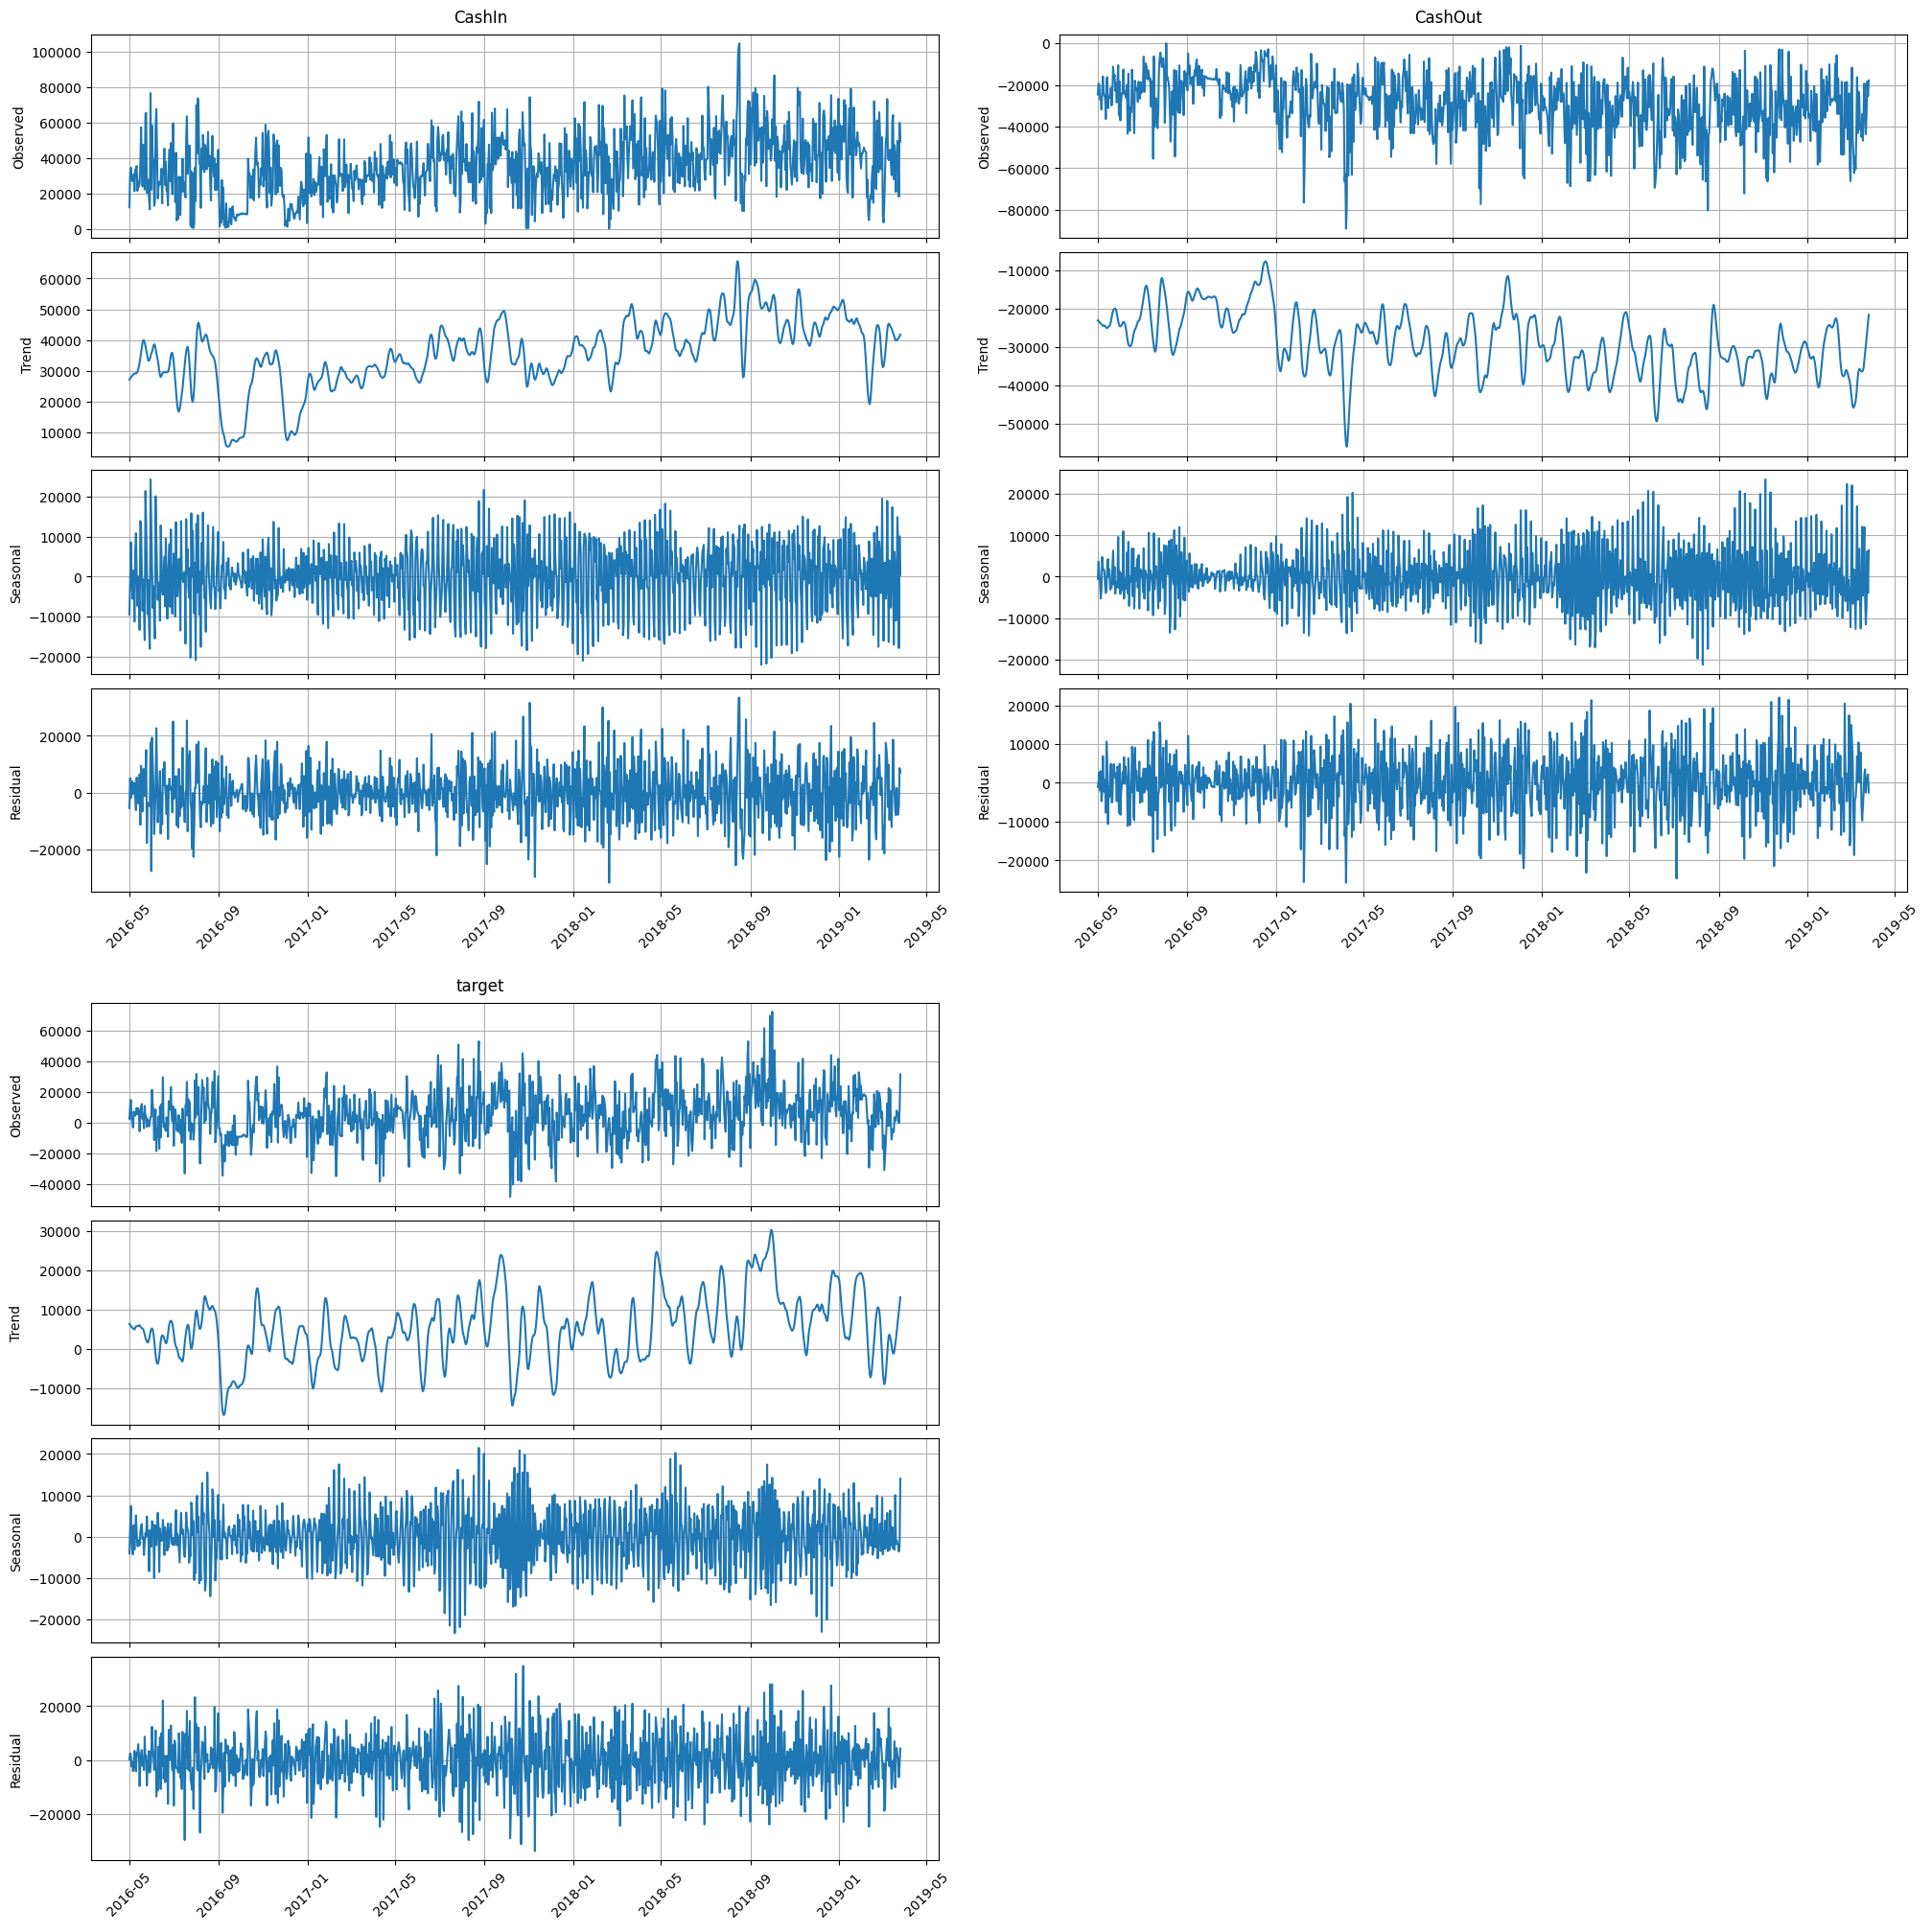

In [348]:
stl_plot(ts=train_ts, period=7)

In [381]:
STL =  STLTransform(in_column="target", period=7, model="arima")

lags14 = LagTransform(in_column="target", lags=list(range(5, 14, 1)))
mean8 = MeanTransform(in_column="target", window=8)

In [408]:
train_ts, test_ts = ts_multi.train_test_split(
    train_start="2016-05-01",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

In [409]:
train_ts_cat = train_ts # создадим копию

In [410]:
train_ts_cat.fit_transform([STL, lags14, mean8])

In [412]:
HORIZON = 5

model = CatBoostMultiSegmentModel()
model.fit(train_ts_cat)
future_ts = train_ts_cat.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'CashIn': 44.41005136629626,
 'target': 112.09492958119883,
 'CashOut': 43.29138020563729}

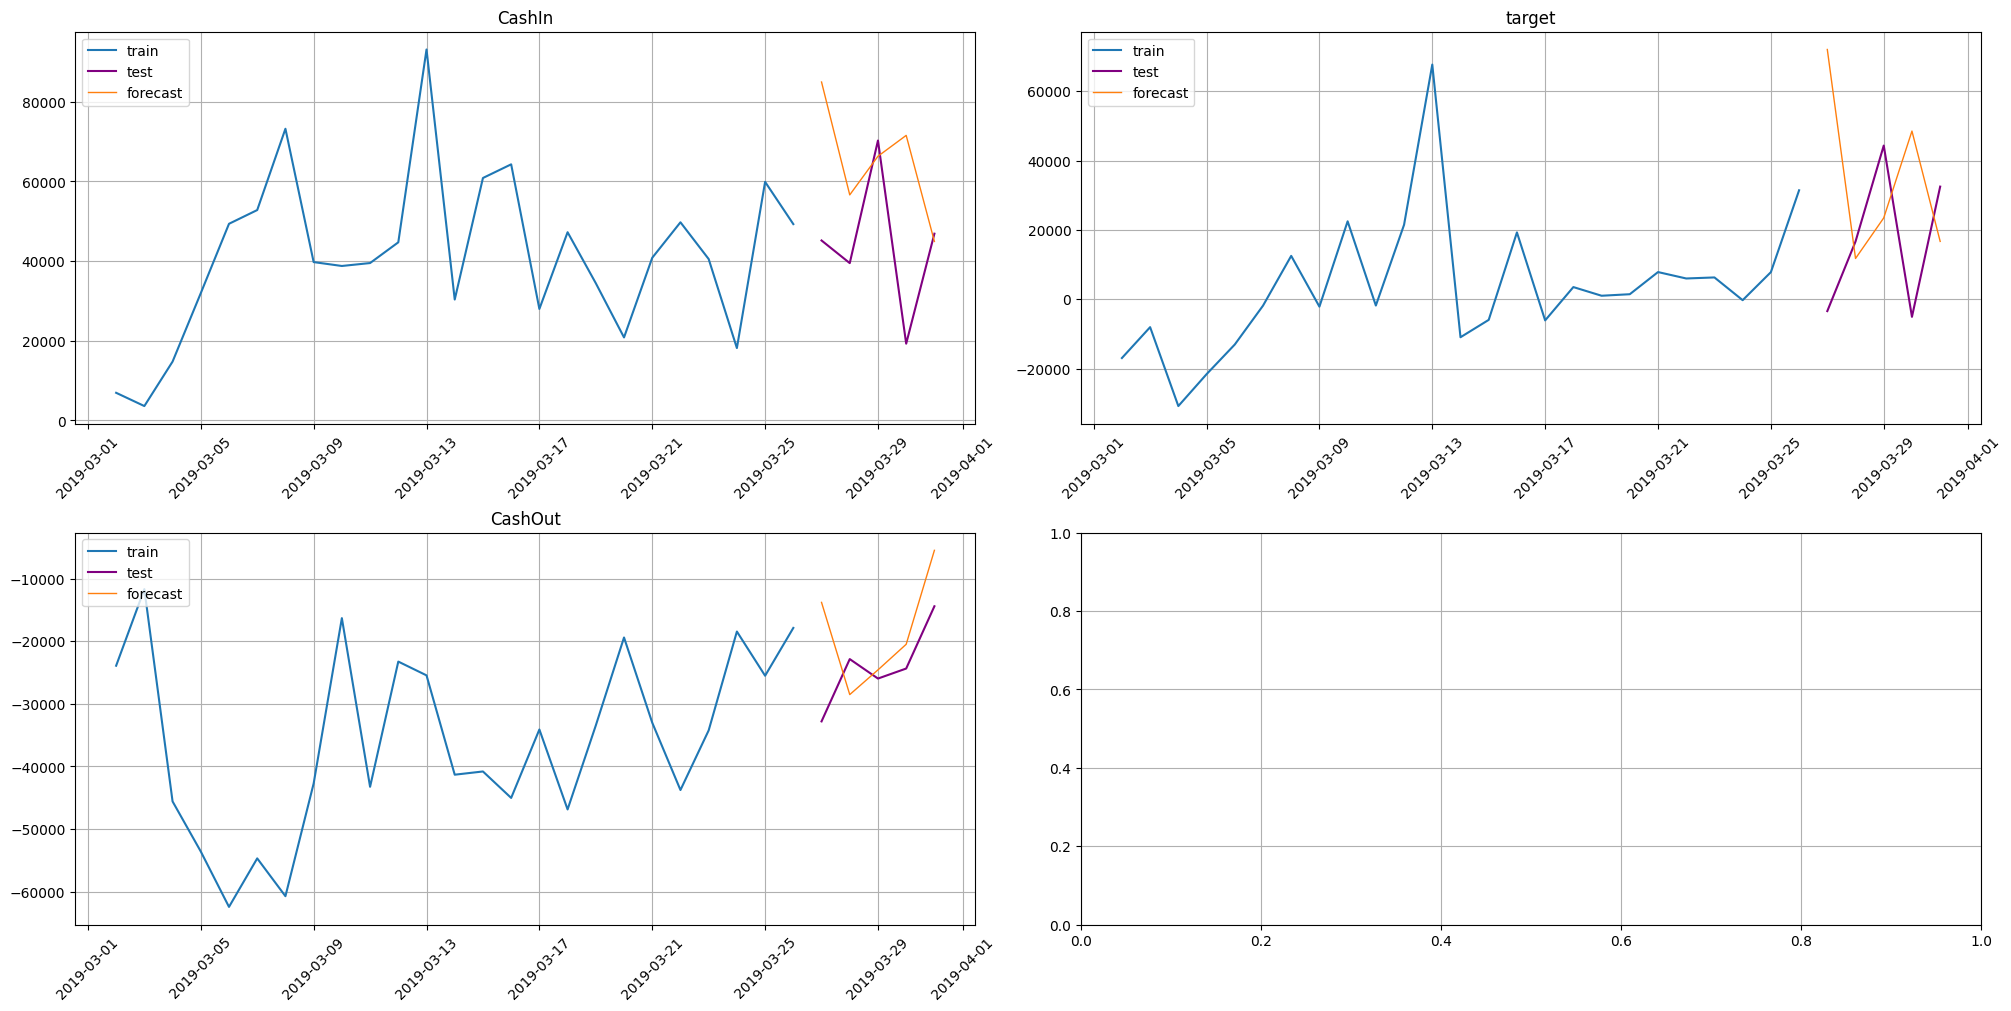

In [413]:
train_ts_cat.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts_cat, n_train_samples=25)

In [416]:
train_ts, test_ts = ts_multi.train_test_split(
    train_start="2016-05-01",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

train_ts_cat = train_ts # создадим копию
train_ts_cat.fit_transform([STL, lags14, d_flags, mean8])

In [417]:
HORIZON = 5

model = CatBoostMultiSegmentModel()
model.fit(train_ts_cat)
future_ts = train_ts_cat.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'CashIn': 38.19762495514495,
 'target': 118.33021047199654,
 'CashOut': 23.191992826767954}

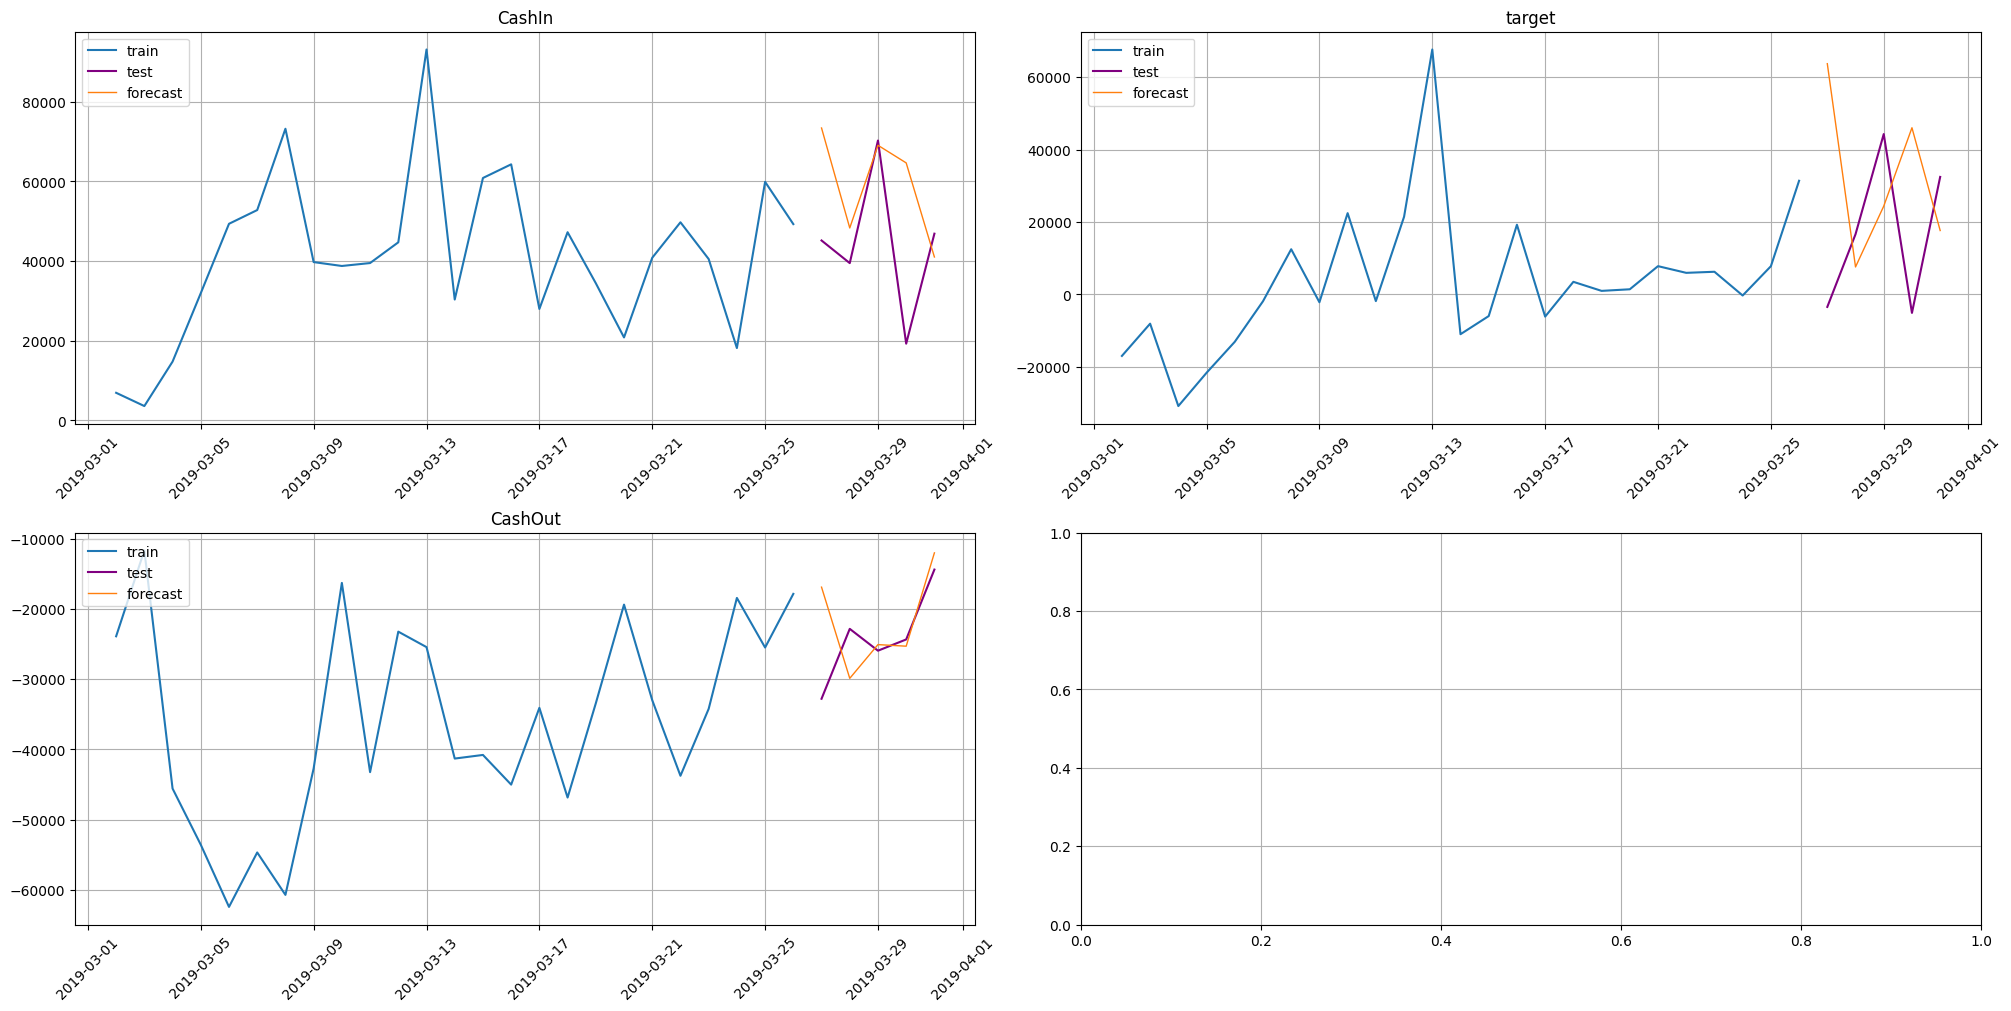

In [418]:
train_ts_cat.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts_cat, n_train_samples=25)

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [419]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

## Catboost с разными стратегиями прогнозирования

### 1.Прямая

In [438]:
model = CatBoostMultiSegmentModel()

pipeline = Pipeline(model=model, transforms=[STL, lags14, d_flags, mean8], horizon=HORIZON)

metrics_pipeline_df, forecast_pipeline_df, _ = pipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE(), MAPE()]
)

pipeline_metrics = metrics_pipeline_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished


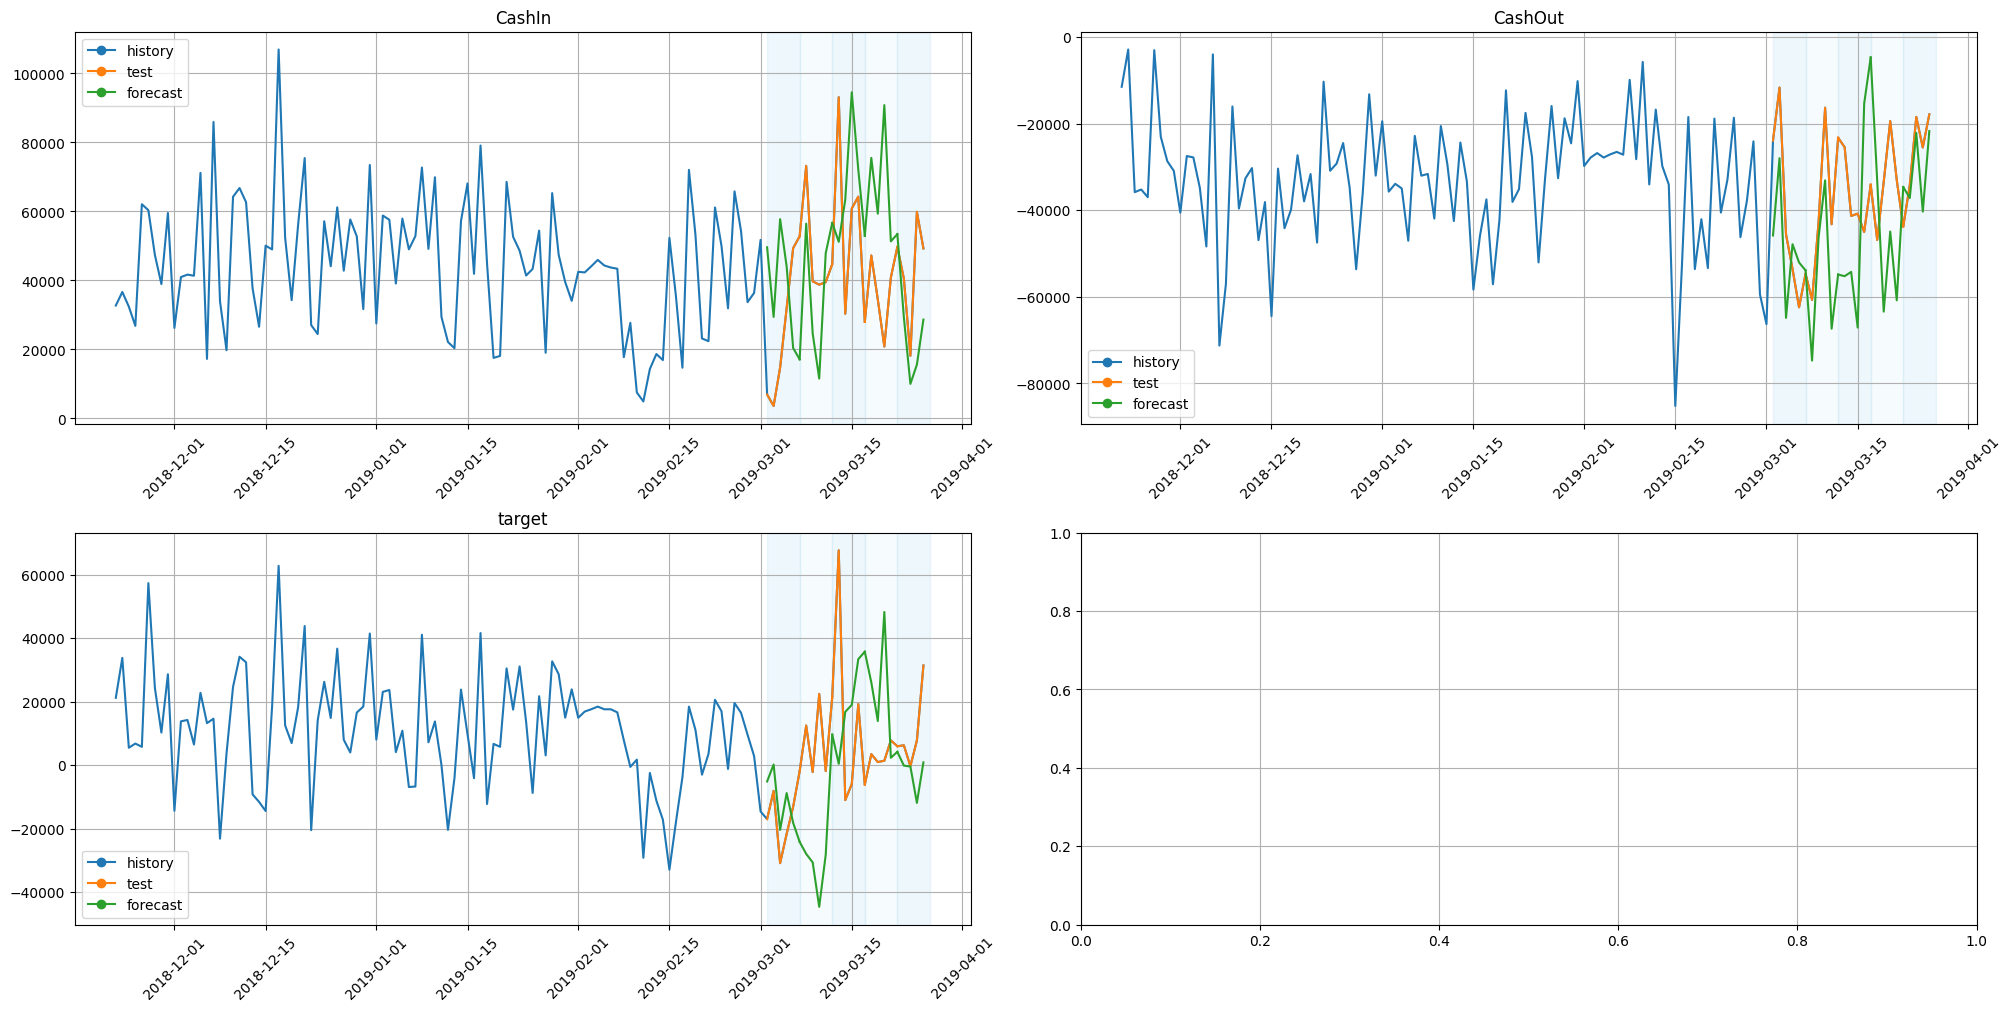

In [439]:
plot_backtest(forecast_pipeline_df, train_ts, history_len=100)

In [440]:
pipeline_metrics

SMAPE          8.533090e+01
MAE            2.163060e+04
MAPE           1.775121e+21
fold_number    2.000000e+00
dtype: float64

### 2. Рекурсивная

In [433]:
model = CatBoostMultiSegmentModel()


autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=[STL, lags14, d_flags, mean8], horizon=HORIZON, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE(), MAPE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished


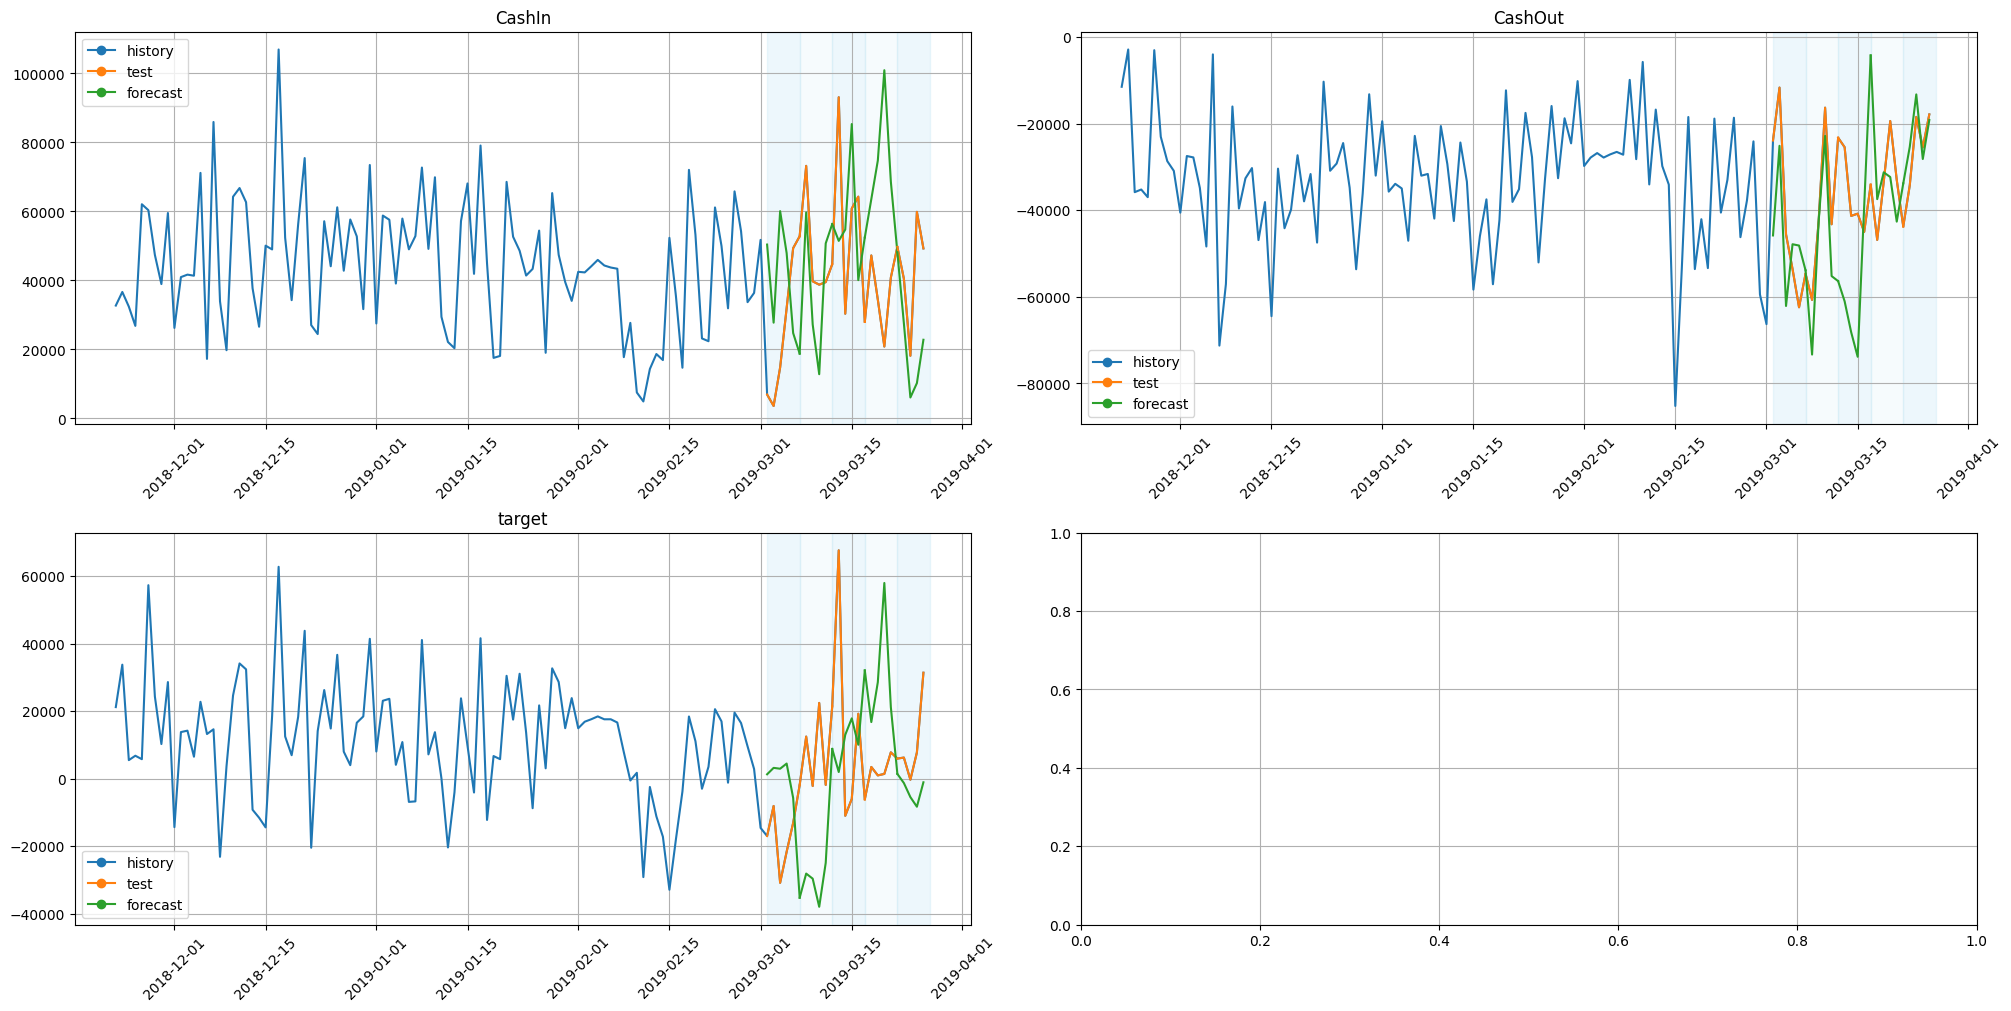

In [435]:
plot_backtest(forecast_recursive_df, train_ts, history_len=100)

In [436]:
autoregressive_pipeline_metrics

SMAPE          9.211139e+01
MAE            2.175385e+04
MAPE           1.625596e+21
fold_number    2.000000e+00
dtype: float64

### 3. Смешанная Direct

In [444]:
horizons = [7, 14]
NUMBER_OF_LAGS = 14

model_1 = CatBoostMultiSegmentModel()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = CatBoostMultiSegmentModel()
transforms_2 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

In [448]:
ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE(), MAPE()]
)

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   1

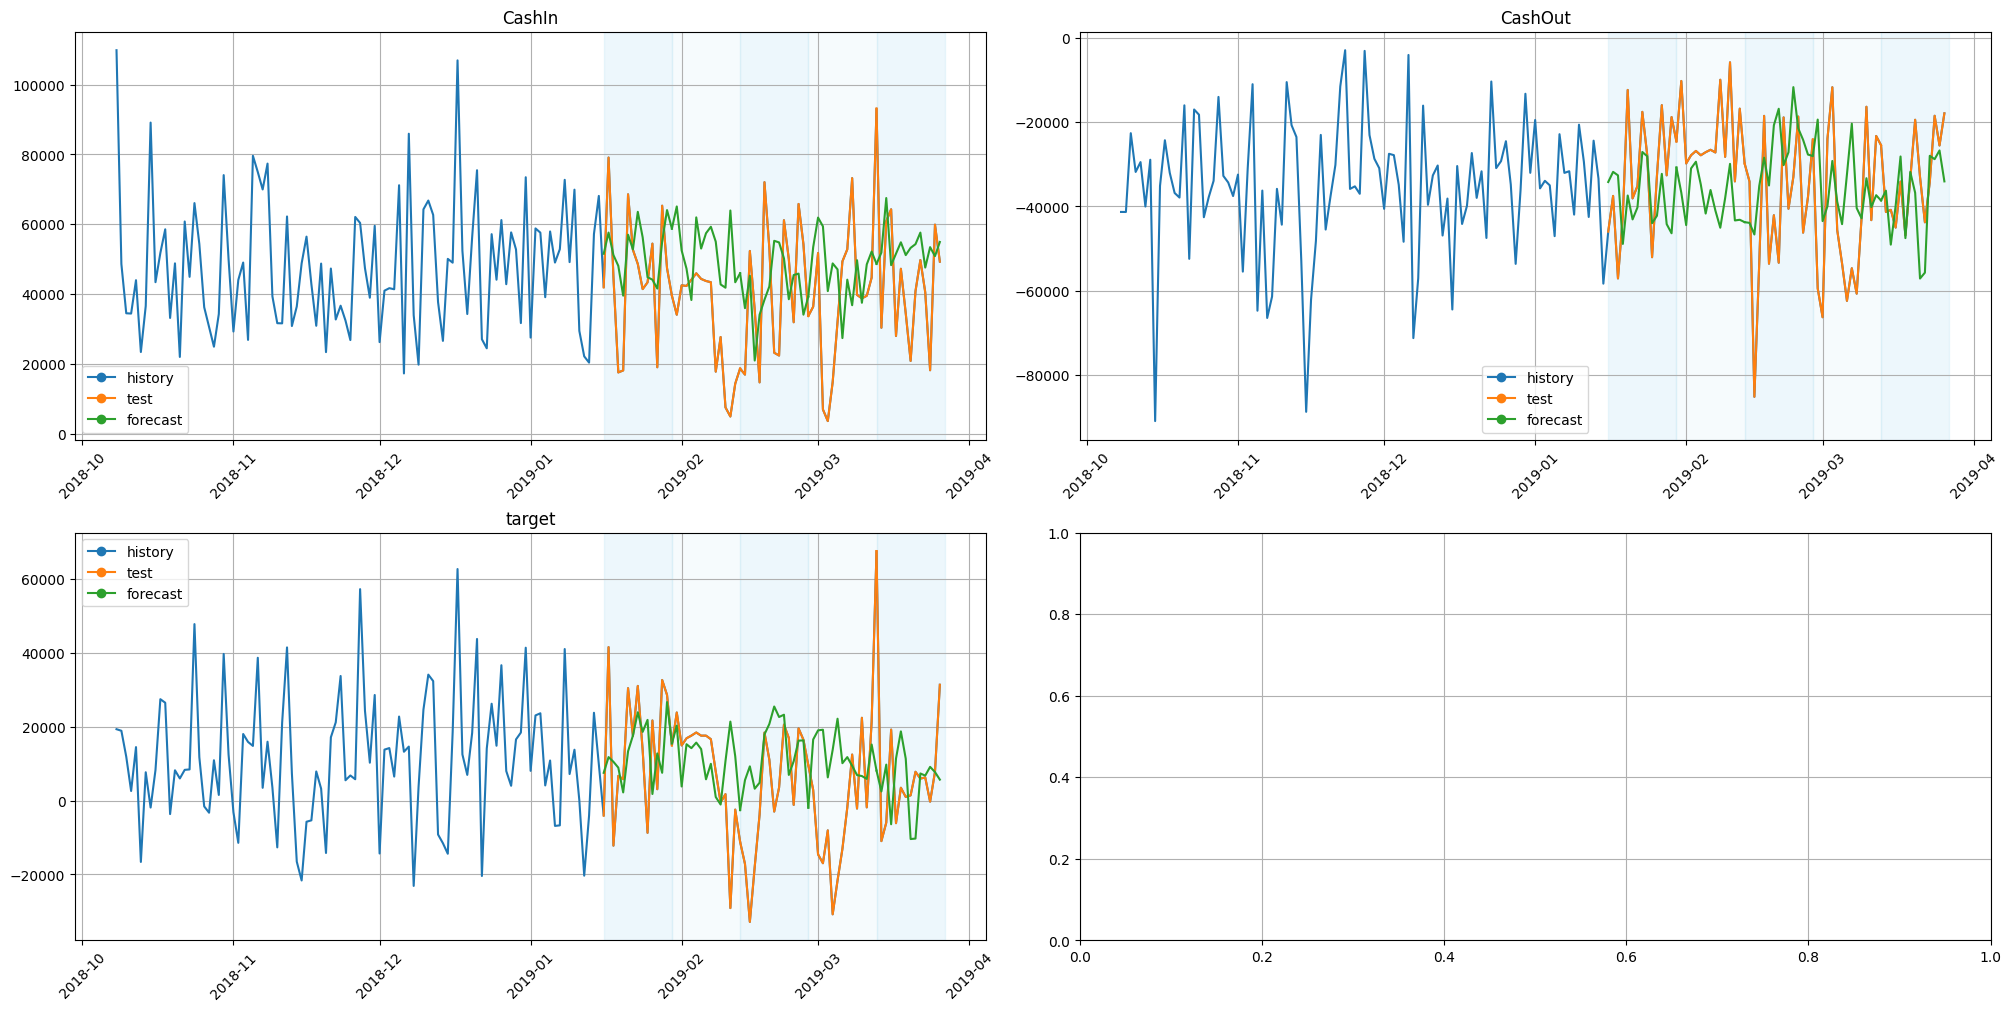

In [450]:
plot_backtest(forecast_ensemble_df, train_ts, history_len=100)

In [452]:
ensemble_metrics

SMAPE          7.025661e+01
MAE            1.553645e+04
MAPE           1.324629e+21
fold_number    2.000000e+00
dtype: float64

## ARIMA с разными стратегиями прогнозирования

### 1.Прямая

In [456]:
model = AutoARIMAModel()

pipeline = Pipeline(model=model, transforms=[STL, d_flags, mean8], horizon=HORIZON)

metrics_pipeline_df, forecast_pipeline_df, _ = pipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE(), MAPE()]
)

pipeline_metrics = metrics_pipeline_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.2min finished


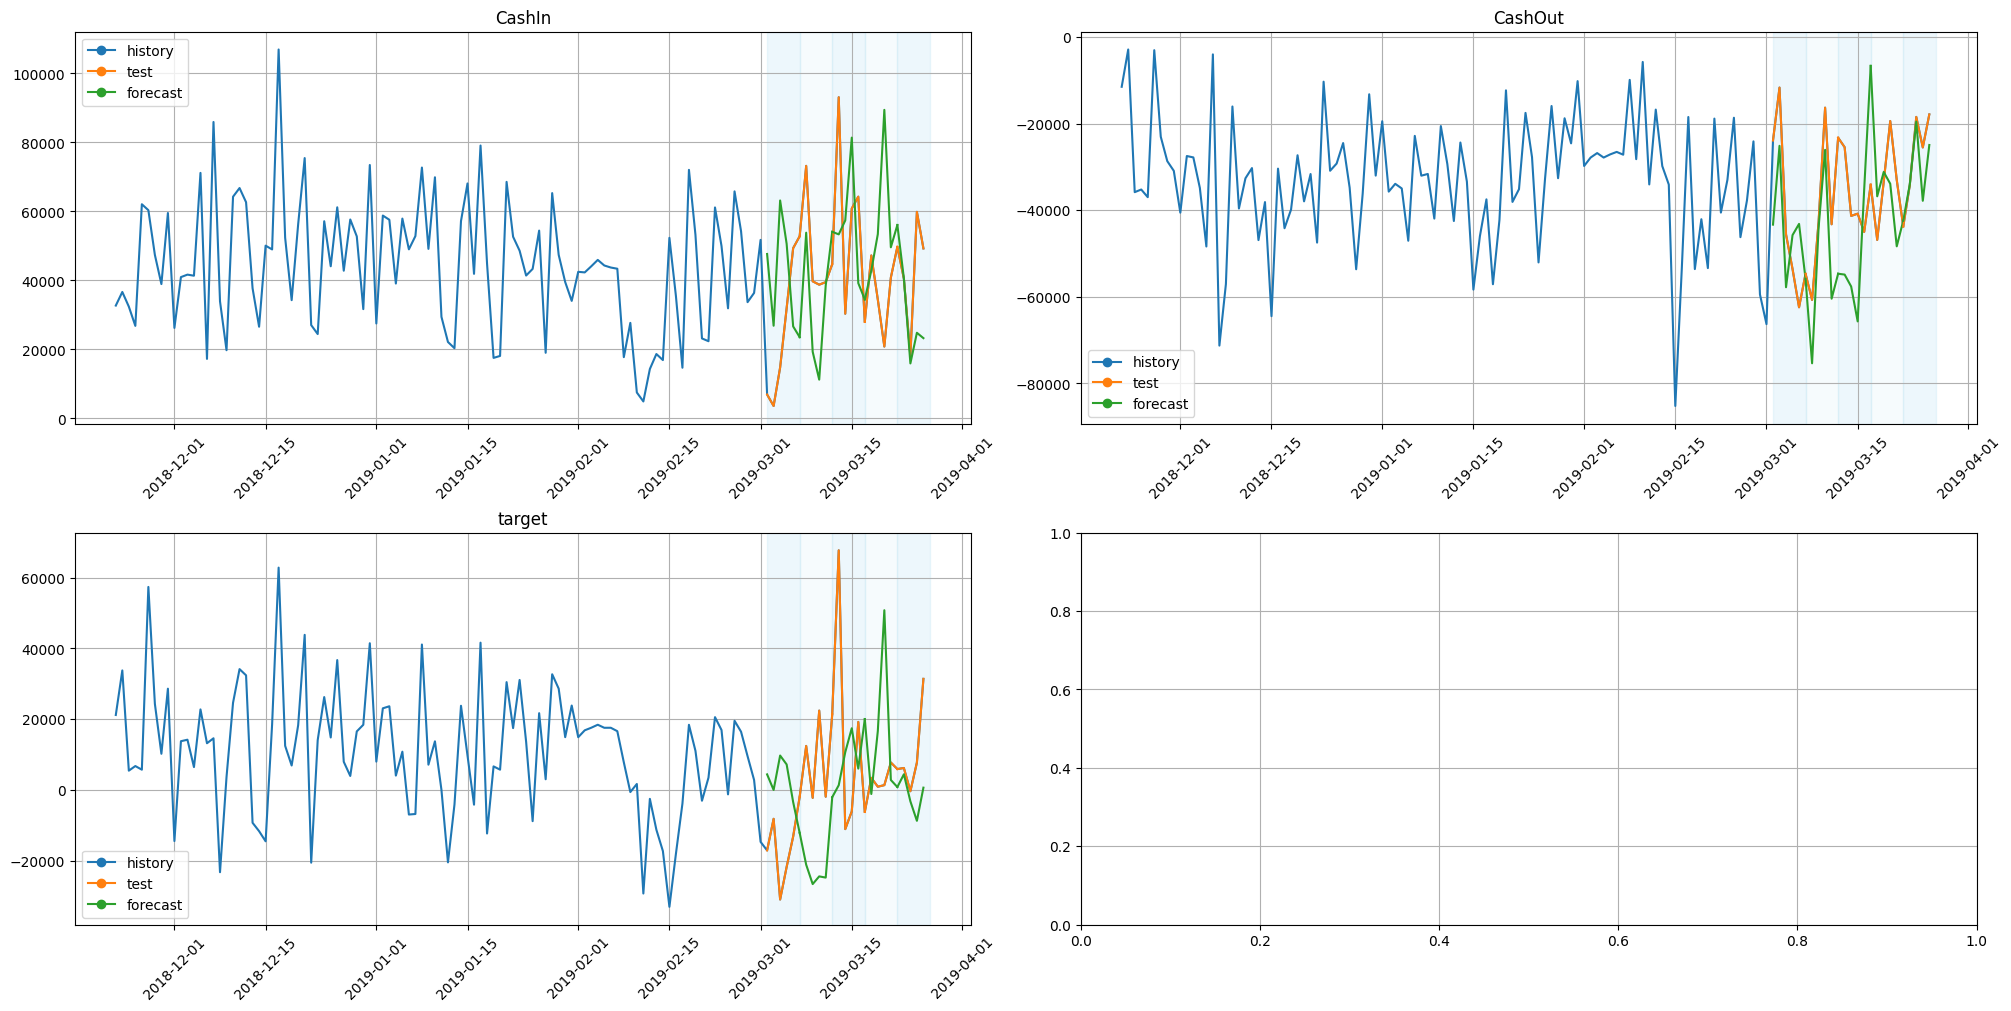

In [457]:
plot_backtest(forecast_pipeline_df, train_ts, history_len=100)

In [458]:
pipeline_metrics

SMAPE          8.852973e+01
MAE            1.895926e+04
MAPE           1.600059e+21
fold_number    2.000000e+00
dtype: float64

## 2. Рекурсивная

In [461]:
model = AutoARIMAModel()


autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=[mean8], horizon=HORIZON, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE(), MAPE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.9min finished


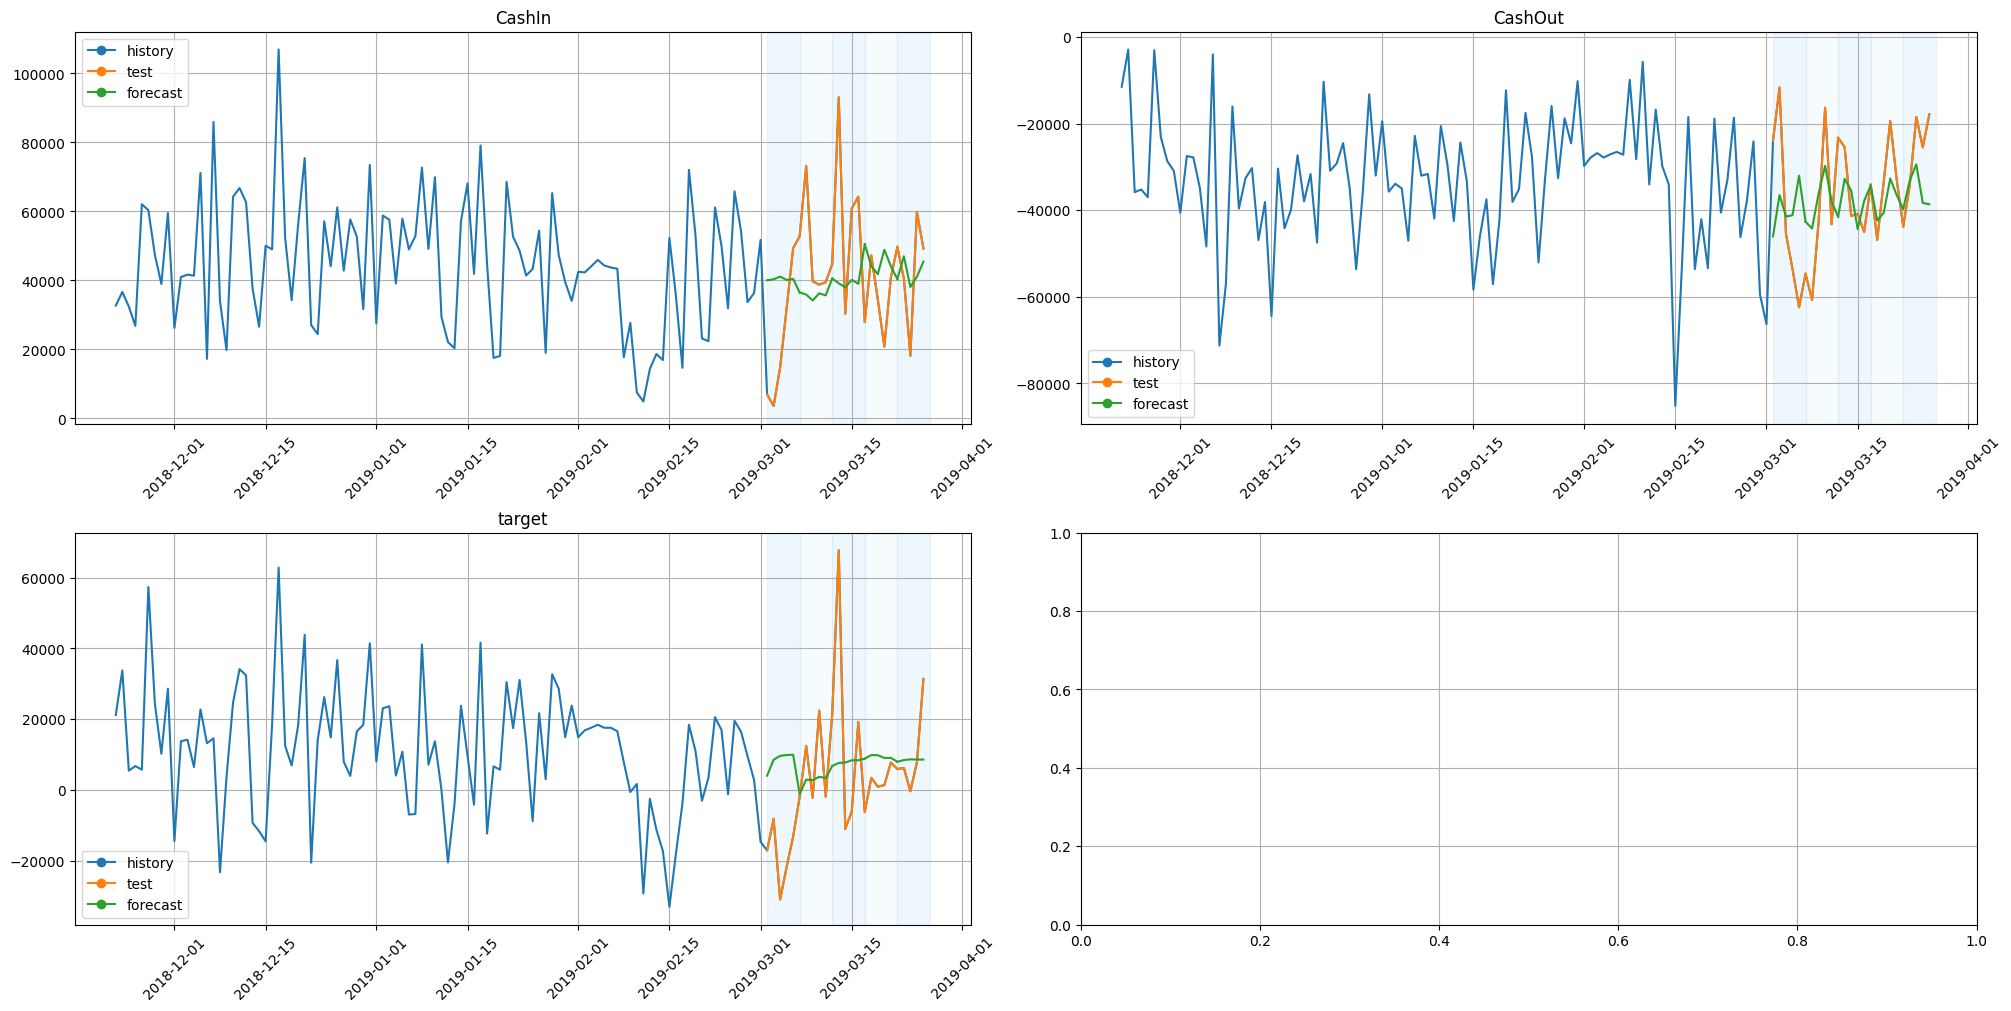

In [471]:
plot_backtest(forecast_recursive_df, train_ts, history_len=100)

In [463]:
autoregressive_pipeline_metrics

SMAPE          7.163141e+01
MAE            1.398487e+04
MAPE           1.372172e+21
fold_number    2.000000e+00
dtype: float64

### 3. Смешанная Direct

In [468]:
horizons = [7, 14]
NUMBER_OF_LAGS = 14

# возникли ошибки при обучении ARIMA,  пришлось оставить только скользящее среднее, то есть моделировать MA без AR
model_1 = AutoARIMAModel()
pipeline_1 = Pipeline(model=model_1, transforms=[mean8], horizon=horizons[0])

mean15 = MeanTransform(in_column="target", window=15)
model_2 = AutoARIMAModel()
pipeline_2 = Pipeline(model=model_2, transforms=[mean15], horizon=horizons[1])

In [469]:
ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE(), MAPE()]
)

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.

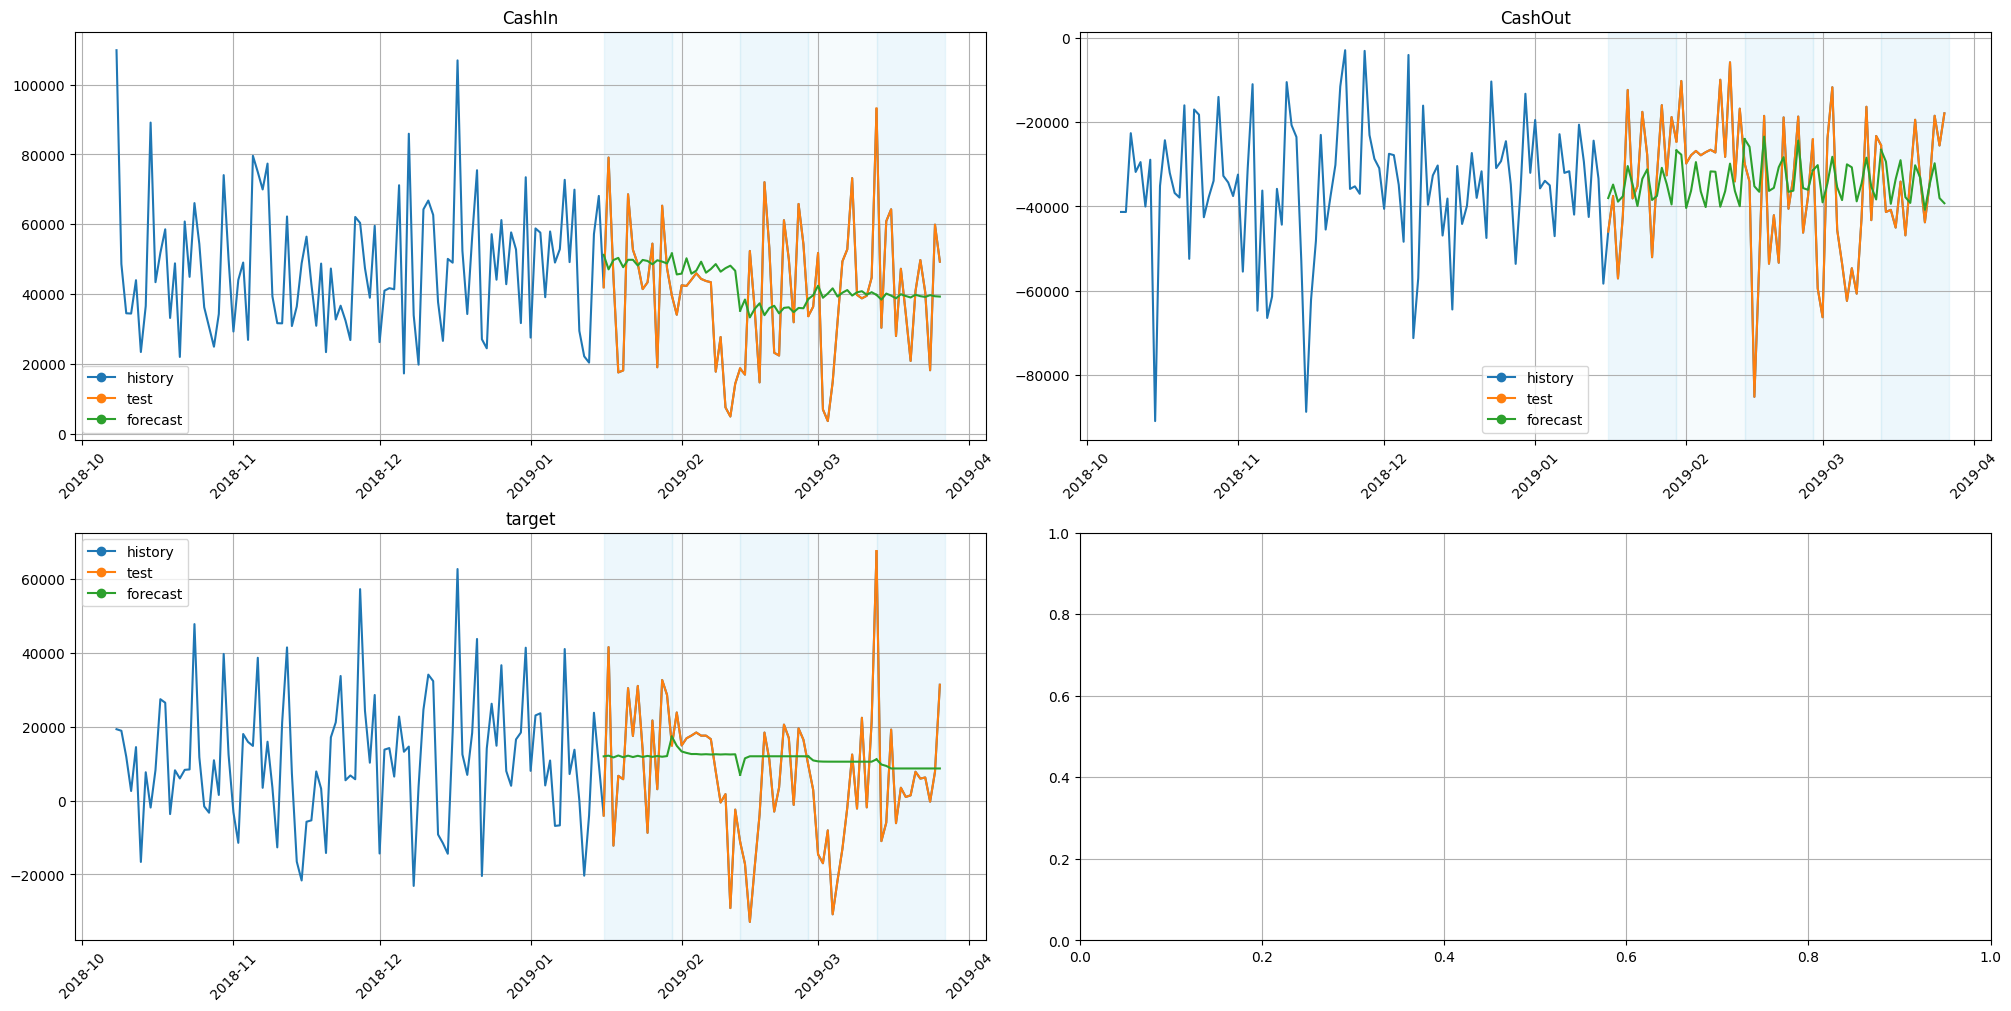

In [472]:
plot_backtest(forecast_ensemble_df, train_ts, history_len=100)

In [473]:
ensemble_metrics

SMAPE          6.308634e+01
MAE            1.342864e+04
MAPE           1.268765e+21
fold_number    2.000000e+00
dtype: float64

Наилучший результат дала смешанная direct тратегия для ARIMA, немного более высокий лосс показала рекурсивная стратегия на CatBoost.

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [475]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [489]:
HORIZON = 5
N_FOLDS = 5



cat_ar = AutoRegressivePipeline(
    model=CatBoostMultiSegmentModel(), transforms=[STL, lags14, d_flags, mean8], horizon=HORIZON, step=1
)


arima = Pipeline(model=AutoARIMAModel(), transforms=[STL, d_flags, mean8], horizon=HORIZON)

pipeline_names = ["catboost", "ARIMA"]
pipelines = [cat_ar, arima]

In [490]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 1], n_jobs=4)

In [488]:
ts_multi

segment      CashIn       CashOut   target
feature      target        target   target
timestamp                                 
2016-01-05  20840.0 -22200.000000  -1360.0
2016-01-06  28460.0 -18810.000000   9650.0
2016-01-07  19250.0 -23210.000000  -3960.0
2016-01-08  49770.0  -4350.000000  45420.0
2016-01-09  29580.0 -17142.500000  12437.5
...             ...           ...      ...
2019-03-27  45160.0 -32795.319658  -3440.0
2019-03-28  39480.0 -22840.000000  16640.0
2019-03-29  70260.0 -25950.000000  44310.0
2019-03-30  19250.0 -24350.000000  -5100.0
2019-03-31  46870.0 -14400.000000  32470.0

[1182 rows x 3 columns]

In [491]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=train_ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]

voting_ensamble_metrics.index = ["CashIn", "CashOut", "target"]
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:  7.4min remaining:  4.9min
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 10.1min finished


MAE           MSE       SMAPE          MAPE
CashIn   24764.612116  8.686870e+08   66.513438  1.136215e+02
CashOut  13611.851349  2.736690e+08   38.807042  4.245398e+21
target   25795.449869  9.665497e+08  169.387508  7.572009e+20

In [493]:
voting_ensemble2 = VotingEnsemble(pipelines=pipelines, weights=[2, 1], n_jobs=4)

voting_ensamble_metrics = voting_ensemble2.backtest(
    ts=train_ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]

voting_ensamble_metrics.index = ["CashIn", "CashOut", "target"]
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:  8.9min remaining:  5.9min
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 11.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 11.3min finished


MAE           MSE       SMAPE          MAPE
CashIn   25998.734899  9.326547e+08   70.669773  1.166826e+02
CashOut  13885.306187  2.877020e+08   39.596474  4.246466e+21
target   27242.479856  1.068993e+09  168.928014  8.238047e+20

In [494]:
voting_ensemble3 = VotingEnsemble(pipelines=pipelines, weights=[1, 2], n_jobs=4)

voting_ensamble_metrics = voting_ensemble3.backtest(
    ts=train_ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]

voting_ensamble_metrics.index = ["CashIn", "CashOut", "target"]
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:  5.2min remaining:  3.5min
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.1min finished


MAE           MSE       SMAPE          MAPE
CashIn   23566.876327  8.160686e+08   62.656425  1.108706e+02
CashOut  13338.396506  2.616730e+08   38.013152  4.244331e+21
target   24434.863103  8.770670e+08  168.177233  6.905971e+20

Наилучшие результаты показал Voting ансамбль с весами [1,2]

In [505]:
stacking_ensemble_unfeatured = StackingEnsemble(
    pipelines=pipelines, n_folds=10, n_jobs=4, features_to_use = None
)

In [506]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=train_ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2
)[0].iloc[:, 1:]
stacking_ensamble_metrics.index = ["CashIn", "CashOut", "target"]
stacking_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.


KeyError: 'target'

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#